### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

### Loading the data

In [4]:
official_names = ['Pinene', 'Limonene']

In [5]:
mix = np.loadtxt(os.getcwd()+'/limonene_pinene_nakrywajace_sie.csv', skiprows=0, usecols=range(2), 
                      delimiter='\t',dtype=float)
ppm = mix[:,0]
mix = mix[:,1]

comp = np.loadtxt(os.getcwd()+'/library.csv', skiprows=1, usecols=[0, 1, 3],
                      delimiter='\t',dtype=float)
ppm_components = comp[:,0]
components = comp[:,1:]

In [6]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [7]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [8]:
mix = Spectrum(confs=list(zip(ppm,mix)))

<IPython.core.display.Javascript object>


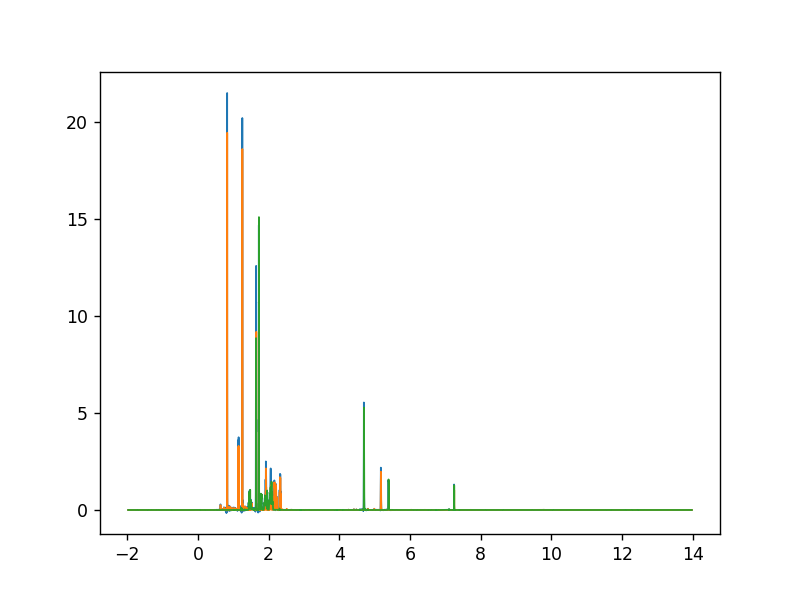

In [9]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)

### Ground truth

In [10]:
protons = [16, 16]
molar_masses = [136.24, 136.24]
mass_proportions = [0.505, 0.495]

In [11]:
molar_proportions = [mass_prop/mol_mass for mass_prop, mol_mass in zip(mass_proportions, molar_masses)]
molar_proportions = [mol_prop/sum(molar_proportions) for mol_prop in molar_proportions]
molar_proportions

[0.505, 0.495]

In [12]:
real_visible_proportions = [prot*prop for prot, prop in zip(protons, molar_proportions)]
real_visible_proportions = [prop/sum(real_visible_proportions) for prop in real_visible_proportions]

In [13]:
real_visible_proportions

[0.505, 0.495]

### Preprocessing

In [14]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [15]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [16]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [17]:
spectra_and_mixture = spectra + [mix]

In [18]:
spectra_and_mixture = shift(spectra_and_mixture)

In [19]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [20]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [21]:
cma = common_mass_axis(spectra_and_mixture)

In [22]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [23]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [24]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [25]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [26]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

<IPython.core.display.Javascript object>


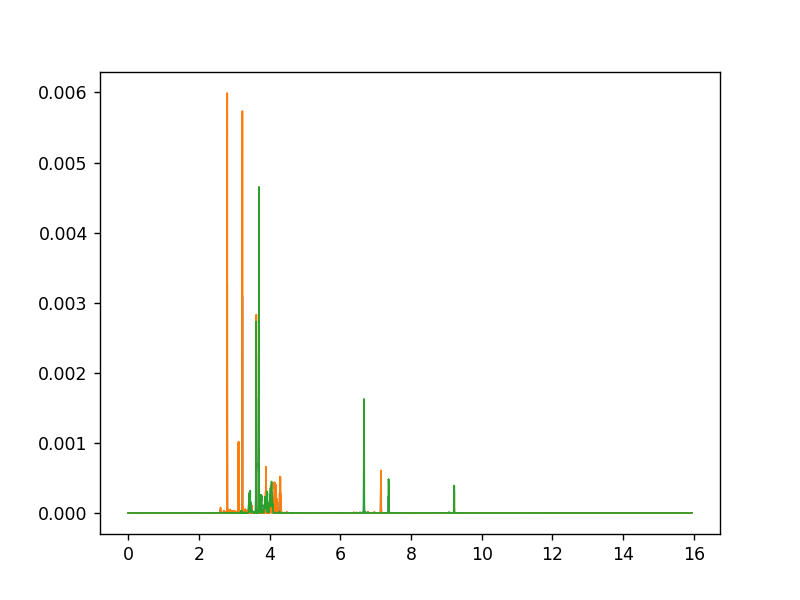

In [27]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 

### Removing unnecessary data points

In [28]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.Spectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [29]:
#2.5, 9.3
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, 2.5, 9.3)

In [30]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [31]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [32]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [33]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

<IPython.core.display.Javascript object>


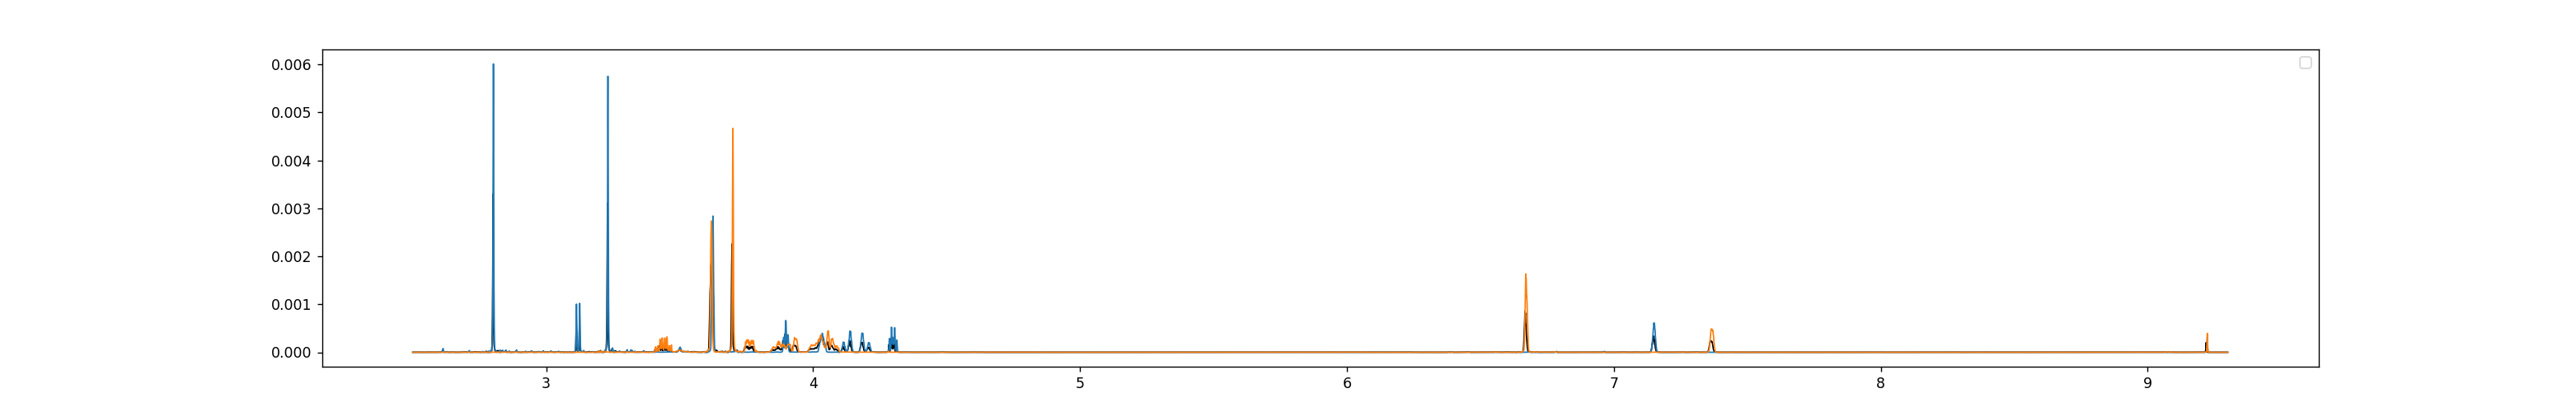

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 4, forward=True)
mix.plot(profile=True, color='black')
comp0.plot(profile=True)
comp1.plot(profile=True) 
ax.legend()

### Finding best values of parameters

In [35]:
import time
import pandas as pd
import pulp

In [36]:
lower_limit = 0.01
upper_limit = 0.31
step = 0.01

In [43]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2903976.69it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.47s/it]


Estimation for 0.01 and 0.01 done
It took: 48.55851864814758 seconds.
[0.4976234950329988, 0.47235427058499885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2567086.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.10s/it]


Estimation for 0.01 and 0.02 done
It took: 56.190555572509766 seconds.
[0.49303613192099877, 0.46713786222399883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20763.88it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1962338.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.88s/it]


Estimation for 0.01 and 0.03 done
It took: 77.98936557769775 seconds.
[0.4820175488099988, 0.4640866432719989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14614.30it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2324177.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.44s/it]


Estimation for 0.01 and 0.04 done
It took: 42.52923274040222 seconds.
[0.4811351827879988, 0.4609392961069989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2649198.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.56s/it]


Estimation for 0.01 and 0.05 done
It took: 41.64396643638611 seconds.
[0.48100386530499883, 0.45951725748599886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3010425.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.81s/it]


Estimation for 0.01 and 0.060000000000000005 done
It took: 40.88835263252258 seconds.
[0.4810684066409988, 0.45780483419899887]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39568.91it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2766346.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.38s/it]


Estimation for 0.01 and 0.06999999999999999 done
It took: 47.46093726158142 seconds.
[0.4793416194369988, 0.4576370483019989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32513.98it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2011806.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.38s/it]


Estimation for 0.01 and 0.08 done
It took: 77.49682378768921 seconds.
[0.47721591475499886, 0.45779831861499887]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2496725.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.32s/it]


Estimation for 0.01 and 0.09 done
It took: 48.40600633621216 seconds.
[0.4749618158339988, 0.4581686172639989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2865610.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.39s/it]


Estimation for 0.01 and 0.09999999999999999 done
It took: 43.46417760848999 seconds.
[0.47321297191199885, 0.4580732375659989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2855142.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.04s/it]


Estimation for 0.01 and 0.11 done
It took: 41.120940923690796 seconds.
[0.4718910463189988, 0.4580229529879989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2682784.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.51s/it]


Estimation for 0.01 and 0.12 done
It took: 46.59464406967163 seconds.
[0.47066406733699884, 0.4573935677709989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2599618.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.52s/it]


Estimation for 0.01 and 0.13 done
It took: 72.60838603973389 seconds.
[0.4695076975329988, 0.4569845685449989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2490757.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.07s/it]


Estimation for 0.01 and 0.14 done
It took: 50.160961389541626 seconds.
[0.46869024866299885, 0.4561689972789989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2780848.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.78s/it]


Estimation for 0.01 and 0.15000000000000002 done
It took: 40.85578465461731 seconds.
[0.4678633095759988, 0.4555552778349989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3005909.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.19s/it]


Estimation for 0.01 and 0.16 done
It took: 39.259541034698486 seconds.
[0.46743560954099883, 0.4545706054239989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2638437.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.26s/it]


Estimation for 0.01 and 0.17 done
It took: 46.33609747886658 seconds.
[0.46695836617899883, 0.4535373287789989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24174.66it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2369772.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.83s/it]


Estimation for 0.01 and 0.18000000000000002 done
It took: 75.93269467353821 seconds.
[0.46619356414799884, 0.4522695164589989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2553165.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 52.00s/it]


Estimation for 0.01 and 0.19 done
It took: 52.085773229599 seconds.
[0.46551506879299887, 0.4509977429669989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2888842.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.23s/it]


Estimation for 0.01 and 0.2 done
It took: 40.30564546585083 seconds.
[0.4647932241149989, 0.4497104512689989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2940836.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.53s/it]


Estimation for 0.01 and 0.21000000000000002 done
It took: 44.60422325134277 seconds.
[0.4637489204219989, 0.44836780527999887]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2839238.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.44s/it]


Estimation for 0.01 and 0.22 done
It took: 50.514183044433594 seconds.
[0.4628864117349989, 0.4466691389569989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2377798.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.55s/it]


Estimation for 0.01 and 0.23 done
It took: 74.6417396068573 seconds.
[0.46189250662499887, 0.44537904989799887]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2387337.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.50s/it]


Estimation for 0.01 and 0.24000000000000002 done
It took: 47.59470772743225 seconds.
[0.4612577053489989, 0.4434186978769989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2697506.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.86s/it]


Estimation for 0.01 and 0.25 done
It took: 40.94076108932495 seconds.
[0.4605741476289989, 0.44273903331899894]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2875803.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.25s/it]


Estimation for 0.01 and 0.26 done
It took: 39.32799577713013 seconds.
[0.4599584392779989, 0.4412523795969989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2840442.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.90s/it]


Estimation for 0.01 and 0.27 done
It took: 42.98203229904175 seconds.
[0.4589943742349989, 0.43984967468999897]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35394.97it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1850036.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.49s/it]


Estimation for 0.01 and 0.28 done
It took: 73.61307954788208 seconds.
[0.4580059334809989, 0.4376664857709989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26051.58it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2397835.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.64s/it]


Estimation for 0.01 and 0.29000000000000004 done
It took: 57.73708176612854 seconds.
[0.4571786152589989, 0.43556451183499895]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2735524.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.68s/it]


Estimation for 0.01 and 0.3 done
It took: 46.758872747421265 seconds.
[0.45655966822299887, 0.4340046963809989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2811154.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.58s/it]


Estimation for 0.02 and 0.01 done
It took: 40.65907049179077 seconds.
[0.49788085074999877, 0.48599381876799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2978039.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.10s/it]


Estimation for 0.02 and 0.02 done
It took: 49.17916703224182 seconds.
[0.5041070489009988, 0.47812948593699883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2365420.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.58s/it]


Estimation for 0.02 and 0.03 done
It took: 73.68257355690002 seconds.
[0.5036468334019988, 0.47664848232999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2342474.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.57s/it]


Estimation for 0.02 and 0.04 done
It took: 49.66423273086548 seconds.
[0.5034656075459988, 0.4760698954609988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2872069.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.31s/it]


Estimation for 0.02 and 0.05 done
It took: 39.39197778701782 seconds.
[0.49981956636699876, 0.4767953820249988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2889660.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.48s/it]


Estimation for 0.02 and 0.060000000000000005 done
It took: 40.553592681884766 seconds.
[0.48818848836299883, 0.47855358378699886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2687581.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.44s/it]


Estimation for 0.02 and 0.06999999999999999 done
It took: 39.51494884490967 seconds.
[0.4825524055439988, 0.4796589740639988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2951052.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.86s/it]


Estimation for 0.02 and 0.08 done
It took: 71.95171475410461 seconds.
[0.48187732640599884, 0.4797331182419988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 10192.72it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1739752.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.99s/it]


Estimation for 0.02 and 0.09 done
It took: 51.13239812850952 seconds.
[0.4812490355519988, 0.4797424848249988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2804799.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.86s/it]


Estimation for 0.02 and 0.09999999999999999 done
It took: 39.942302942276 seconds.
[0.48107611724099886, 0.47924366421399883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2914046.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.76s/it]


Estimation for 0.02 and 0.11 done
It took: 39.837810039520264 seconds.
[0.48063235065099885, 0.47864841017099885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27776.85it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2854342.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.38s/it]


Estimation for 0.02 and 0.12 done
It took: 38.45786762237549 seconds.
[0.48008049115799883, 0.47745680949299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2958350.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.28s/it]


Estimation for 0.02 and 0.13 done
It took: 54.357526540756226 seconds.
[0.4794134619359988, 0.4774228990939988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34521.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2171340.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.60s/it]


Estimation for 0.02 and 0.14 done
It took: 85.70004439353943 seconds.
[0.47881197221399885, 0.4773283892399988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2244870.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.31s/it]


Estimation for 0.02 and 0.15000000000000002 done
It took: 40.39893913269043 seconds.
[0.4780772850319988, 0.4772088276129988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2664371.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.11s/it]


Estimation for 0.02 and 0.16 done
It took: 40.186339378356934 seconds.
[0.47739411505499885, 0.47694039755499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2928824.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.18s/it]


Estimation for 0.02 and 0.17 done
It took: 40.25687050819397 seconds.
[0.47683274700199885, 0.4764472030249988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2892762.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.59s/it]


Estimation for 0.02 and 0.18000000000000002 done
It took: 61.683003425598145 seconds.
[0.4764516531949988, 0.47602594871399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36472.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1521119.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.18s/it]


Estimation for 0.02 and 0.19 done
It took: 81.32865333557129 seconds.
[0.4759627268869988, 0.4759315622249988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2717515.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.55s/it]


Estimation for 0.02 and 0.2 done
It took: 40.6362943649292 seconds.
[0.47554302769699885, 0.47583789187099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2818216.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.05s/it]


Estimation for 0.02 and 0.21000000000000002 done
It took: 39.13242435455322 seconds.
[0.47513909849099883, 0.47552463581699883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2893583.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.12s/it]


Estimation for 0.02 and 0.22 done
It took: 39.19059777259827 seconds.
[0.47483931621599884, 0.47540943797999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2896300.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.82s/it]


Estimation for 0.02 and 0.23 done
It took: 48.901851654052734 seconds.
[0.47450991326299885, 0.47520047977599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26051.58it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2123533.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.66s/it]


Estimation for 0.02 and 0.24000000000000002 done
It took: 97.75846338272095 seconds.
[0.47433172718899885, 0.47499842316499885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2831284.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.06s/it]


Estimation for 0.02 and 0.25 done
It took: 39.140591621398926 seconds.
[0.47423727750499883, 0.4747859189929988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2589140.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.00s/it]


Estimation for 0.02 and 0.26 done
It took: 39.08223032951355 seconds.
[0.47406797823599883, 0.47429299679899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2870768.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.05s/it]


Estimation for 0.02 and 0.27 done
It took: 46.123648166656494 seconds.
[0.4739393248409988, 0.47360027160199886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3141850.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.75s/it]


Estimation for 0.02 and 0.28 done
It took: 68.8390257358551 seconds.
[0.4736753649939988, 0.47336730109999886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14488.10it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1264152.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.77s/it]


Estimation for 0.02 and 0.29000000000000004 done
It took: 86.96514940261841 seconds.
[0.47359733690999883, 0.47282950817999886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2826369.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.47s/it]


Estimation for 0.02 and 0.3 done
It took: 39.54943346977234 seconds.
[0.47328045878599884, 0.4718563742949988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2926704.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.94s/it]


Estimation for 0.03 and 0.01 done
It took: 40.01648831367493 seconds.
[0.49509945829699875, 0.49247678342099876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2810750.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.22s/it]


Estimation for 0.03 and 0.02 done
It took: 39.299601316452026 seconds.
[0.5070501470209988, 0.4793642326579988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2772889.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.41s/it]


Estimation for 0.03 and 0.03 done
It took: 45.5018584728241 seconds.
[0.5076389539679987, 0.4790259354409988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1960828.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.18s/it]


Estimation for 0.03 and 0.04 done
It took: 72.30623245239258 seconds.
[0.5078440994859987, 0.47825251741799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1570325.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.66s/it]


Estimation for 0.03 and 0.05 done
It took: 43.76841974258423 seconds.
[0.5072947160049988, 0.4777839370459988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2875274.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.20s/it]


Estimation for 0.03 and 0.060000000000000005 done
It took: 41.27758049964905 seconds.
[0.5052700229129988, 0.47799044873799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2855559.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.93s/it]


Estimation for 0.03 and 0.06999999999999999 done
It took: 40.00472044944763 seconds.
[0.5046828880309988, 0.4778396997609988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2877038.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.66s/it]


Estimation for 0.03 and 0.08 done
It took: 47.7397985458374 seconds.
[0.5013375625659988, 0.47817523739199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2444611.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.27s/it]


Estimation for 0.03 and 0.09 done
It took: 81.36635184288025 seconds.
[0.49219228343799876, 0.47936010015599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2508773.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.94s/it]


Estimation for 0.03 and 0.09999999999999999 done
It took: 48.03097081184387 seconds.
[0.4861224861199988, 0.48011523876199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2723323.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.95s/it]


Estimation for 0.03 and 0.11 done
It took: 39.02980947494507 seconds.
[0.48597936418099885, 0.4798910960069988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2642421.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.84s/it]


Estimation for 0.03 and 0.12 done
It took: 39.91620874404907 seconds.
[0.48546428922699886, 0.4798242139319988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2953729.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.23s/it]


Estimation for 0.03 and 0.13 done
It took: 48.30175828933716 seconds.
[0.4849358030809988, 0.47986282144299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27776.85it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1517045.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.58s/it]


Estimation for 0.03 and 0.14 done
It took: 80.7060067653656 seconds.
[0.4845125161059988, 0.4796350764499988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2233068.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.01s/it]


Estimation for 0.03 and 0.15000000000000002 done
It took: 42.113266468048096 seconds.
[0.4847017249439988, 0.4793837002979988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2881528.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.15s/it]


Estimation for 0.03 and 0.16 done
It took: 50.231568574905396 seconds.
[0.48495439655399886, 0.4788242848429988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36314.32it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2708005.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.05s/it]


Estimation for 0.03 and 0.17 done
It took: 39.125317096710205 seconds.
[0.48471837348999885, 0.47859486830399883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2796236.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.24s/it]


Estimation for 0.03 and 0.18000000000000002 done
It took: 47.32142376899719 seconds.
[0.48422121318399886, 0.4781807128519988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2676689.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.51s/it]


Estimation for 0.03 and 0.19 done
It took: 70.60551476478577 seconds.
[0.4835922432579988, 0.47782591348799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2048506.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.11s/it]


Estimation for 0.03 and 0.2 done
It took: 40.21498346328735 seconds.
[0.48268967709699884, 0.4777410462039988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2952910.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.40s/it]


Estimation for 0.03 and 0.21000000000000002 done
It took: 37.477381229400635 seconds.
[0.4818168357229988, 0.47774924403299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3023351.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.40s/it]


Estimation for 0.03 and 0.22 done
It took: 36.47035789489746 seconds.
[0.4810828353719988, 0.4777963410339988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3083873.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.28s/it]


Estimation for 0.03 and 0.23 done
It took: 42.35482907295227 seconds.
[0.4802526970039988, 0.4778389172609988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25890.77it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2367331.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.21s/it]


Estimation for 0.03 and 0.24000000000000002 done
It took: 41.29384517669678 seconds.
[0.47955405943999885, 0.47786419299599886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2955404.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.17s/it]


Estimation for 0.03 and 0.25 done
It took: 36.24899172782898 seconds.
[0.4789397399129988, 0.4778915600579988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2973243.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.08s/it]


Estimation for 0.03 and 0.26 done
It took: 44.15380668640137 seconds.
[0.4783185773229988, 0.47786348157499886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2912453.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.54s/it]


Estimation for 0.03 and 0.27 done
It took: 48.619850158691406 seconds.
[0.4777046338279988, 0.4777761750969988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2434786.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.71s/it]


Estimation for 0.03 and 0.28 done
It took: 44.80702495574951 seconds.
[0.47738982123799883, 0.47763697085199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3050690.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.72s/it]


Estimation for 0.03 and 0.29000000000000004 done
It took: 35.78881883621216 seconds.
[0.47714088763499884, 0.4774810001179988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3000601.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.40s/it]


Estimation for 0.03 and 0.3 done
It took: 35.47660303115845 seconds.
[0.4770320065109988, 0.47728205400799883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3075742.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.99s/it]


Estimation for 0.04 and 0.01 done
It took: 38.059391260147095 seconds.
[0.4981141452509988, 0.49185250670199876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2971058.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.66s/it]


Estimation for 0.04 and 0.02 done
It took: 44.73858118057251 seconds.
[0.5084586386849987, 0.4795172336829988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2320129.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.84s/it]


Estimation for 0.04 and 0.03 done
It took: 42.93192005157471 seconds.
[0.5093301196079988, 0.4791955567019988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2968726.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.07s/it]


Estimation for 0.04 and 0.04 done
It took: 38.144038915634155 seconds.
[0.5093788092159988, 0.4792250331319988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2924404.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.89s/it]


Estimation for 0.04 and 0.05 done
It took: 39.96487069129944 seconds.
[0.5090446654139987, 0.47903126081599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2869714.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.08s/it]


Estimation for 0.04 and 0.060000000000000005 done
It took: 37.15052533149719 seconds.
[0.5088327444099988, 0.47848188934599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3023156.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.63s/it]


Estimation for 0.04 and 0.06999999999999999 done
It took: 42.699716329574585 seconds.
[0.5086557439659988, 0.47810505239299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2898305.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.83s/it]


Estimation for 0.04 and 0.08 done
It took: 39.90397810935974 seconds.
[0.5080697733219988, 0.47798261734099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2974978.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.28s/it]


Estimation for 0.04 and 0.09 done
It took: 38.34918475151062 seconds.
[0.5060239359259988, 0.47811051452799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3057453.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.28s/it]


Estimation for 0.04 and 0.09999999999999999 done
It took: 37.348851680755615 seconds.
[0.5052143048279988, 0.4776643514719988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3058729.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.23s/it]


Estimation for 0.04 and 0.11 done
It took: 48.30617046356201 seconds.
[0.5023395148739987, 0.47779535416999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38657.18it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1741717.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.15s/it]


Estimation for 0.04 and 0.12 done
It took: 46.2725875377655 seconds.
[0.49884753667999876, 0.47859554969499885]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3022533.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.37s/it]


Estimation for 0.04 and 0.13 done
It took: 41.43537187576294 seconds.
[0.49328835251499875, 0.4799631106039988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3021676.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.31s/it]


Estimation for 0.04 and 0.14 done
It took: 37.379868268966675 seconds.
[0.49044317669499876, 0.48061759434299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3053392.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.06s/it]


Estimation for 0.04 and 0.15000000000000002 done
It took: 37.12919545173645 seconds.
[0.4898504053099988, 0.4804651515039988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2896622.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.26s/it]


Estimation for 0.04 and 0.16 done
It took: 46.33682584762573 seconds.
[0.4879982398009988, 0.4804146448869988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2240323.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.80s/it]


Estimation for 0.04 and 0.17 done
It took: 44.89513611793518 seconds.
[0.48618564631399885, 0.48039256290599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2754128.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.49s/it]


Estimation for 0.04 and 0.18000000000000002 done
It took: 36.56289839744568 seconds.
[0.4856725686219988, 0.48031683275799886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2864140.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.91s/it]


Estimation for 0.04 and 0.19 done
It took: 36.98255205154419 seconds.
[0.48561264501699886, 0.4802260526809988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3005062.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.60s/it]


Estimation for 0.04 and 0.2 done
It took: 37.671154737472534 seconds.
[0.48555764828599884, 0.4801414287799988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3077397.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.55s/it]


Estimation for 0.04 and 0.21000000000000002 done
It took: 47.6231153011322 seconds.
[0.4852455896749988, 0.4801706112129988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2465976.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.63s/it]


Estimation for 0.04 and 0.22 done
It took: 40.71401858329773 seconds.
[0.48496470194999886, 0.4801878164699988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2913213.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.97s/it]


Estimation for 0.04 and 0.23 done
It took: 37.04193449020386 seconds.
[0.4844803438629988, 0.4802246022919988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3087731.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.64s/it]


Estimation for 0.04 and 0.24000000000000002 done
It took: 35.715598344802856 seconds.
[0.48409834172199884, 0.48029370367099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38130.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2785406.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.65s/it]


Estimation for 0.04 and 0.25 done
It took: 45.72814154624939 seconds.
[0.4837737681409988, 0.4803335019269988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3012397.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.70s/it]


Estimation for 0.04 and 0.26 done
It took: 45.7748498916626 seconds.
[0.48336395694699885, 0.4803503212729988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2434458.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.11s/it]


Estimation for 0.04 and 0.27 done
It took: 38.20340609550476 seconds.
[0.48289159227399886, 0.48019650730099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2987145.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.70s/it]


Estimation for 0.04 and 0.28 done
It took: 36.77682042121887 seconds.
[0.48249496592099883, 0.48009732126099885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2580705.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.30s/it]


Estimation for 0.04 and 0.29000000000000004 done
It took: 59.376508712768555 seconds.
[0.4821748071049988, 0.4799258099709988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33288.13it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2540193.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.61s/it]


Estimation for 0.04 and 0.3 done
It took: 45.69132375717163 seconds.
[0.48164888908899883, 0.4800222540779988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2513291.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.97s/it]


Estimation for 0.05 and 0.01 done
It took: 43.055022954940796 seconds.
[0.4998192564689988, 0.4913159499439988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2956746.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.74s/it]


Estimation for 0.05 and 0.02 done
It took: 37.81271195411682 seconds.
[0.5096603636529988, 0.4795249672729988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20763.88it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2909778.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.01s/it]


Estimation for 0.05 and 0.03 done
It took: 37.08121991157532 seconds.
[0.5104572092619988, 0.47880134674799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2934102.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.10s/it]


Estimation for 0.05 and 0.04 done
It took: 37.17718744277954 seconds.
[0.5104932446199988, 0.47896389373799886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3059208.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.91s/it]


Estimation for 0.05 and 0.05 done
It took: 47.982704162597656 seconds.
[0.5103326917849987, 0.4791214587789988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2441047.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.11s/it]


Estimation for 0.05 and 0.060000000000000005 done
It took: 40.20226001739502 seconds.
[0.5104745196269987, 0.47886894682299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34952.53it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2815272.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.21s/it]


Estimation for 0.05 and 0.06999999999999999 done
It took: 37.28787446022034 seconds.
[0.5106277764999988, 0.47842146183299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39199.10it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2862776.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.32s/it]


Estimation for 0.05 and 0.08 done
It took: 38.38737750053406 seconds.
[0.5099631383359988, 0.4781735598499988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3029210.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.22s/it]


Estimation for 0.05 and 0.09 done
It took: 39.294371128082275 seconds.
[0.5091772663169988, 0.4780399115849988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28630.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2178016.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.56s/it]


Estimation for 0.05 and 0.09999999999999999 done
It took: 49.65819692611694 seconds.
[0.5088645852989988, 0.47781074635399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2815407.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.94s/it]


Estimation for 0.05 and 0.11 done
It took: 38.012271881103516 seconds.
[0.5084048812899988, 0.47748877267299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2967035.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.84s/it]


Estimation for 0.05 and 0.12 done
It took: 38.90742230415344 seconds.
[0.5062649738959988, 0.47712873073999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2970681.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.58s/it]


Estimation for 0.05 and 0.13 done
It took: 37.65161895751953 seconds.
[0.5052653265999988, 0.47710235931399886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2975658.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.38s/it]


Estimation for 0.05 and 0.14 done
It took: 49.455819606781006 seconds.
[0.5031665092919988, 0.4776589295229988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2604469.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.04s/it]


Estimation for 0.05 and 0.15000000000000002 done
It took: 50.12450098991394 seconds.
[0.5002977428399987, 0.47835251092299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2983534.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.57s/it]


Estimation for 0.05 and 0.16 done
It took: 40.63966202735901 seconds.
[0.4951727749599988, 0.4796571821169988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2987259.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.35s/it]


Estimation for 0.05 and 0.17 done
It took: 42.42010569572449 seconds.
[0.4927062670889988, 0.4804665202089988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2864350.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.97s/it]


Estimation for 0.05 and 0.18000000000000002 done
It took: 45.05417323112488 seconds.
[0.4915816519189988, 0.48100743941299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30954.27it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2253522.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.52s/it]


Estimation for 0.05 and 0.19 done
It took: 47.61268734931946 seconds.
[0.49123429044099876, 0.4811913434869988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2757756.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.27s/it]


Estimation for 0.05 and 0.2 done
It took: 36.347941875457764 seconds.
[0.49066732228299875, 0.48142884446999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3078771.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.53s/it]


Estimation for 0.05 and 0.21000000000000002 done
It took: 36.60623621940613 seconds.
[0.48984299891799876, 0.48171445937999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38836.15it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2588797.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.73s/it]


Estimation for 0.05 and 0.22 done
It took: 37.810320138931274 seconds.
[0.48830004550699885, 0.48210619612899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3051365.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.95s/it]


Estimation for 0.05 and 0.23 done
It took: 37.03060340881348 seconds.
[0.4875561541899988, 0.4822242341499988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2085234.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.82s/it]


Estimation for 0.05 and 0.24000000000000002 done
It took: 45.937092304229736 seconds.
[0.48727471853599885, 0.48215848456899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2638496.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.79s/it]


Estimation for 0.05 and 0.25 done
It took: 36.86775183677673 seconds.
[0.4872464718319988, 0.48196975939599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2977661.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.61s/it]


Estimation for 0.05 and 0.26 done
It took: 37.68419671058655 seconds.
[0.48713741254399884, 0.48171435006299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3046805.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.65s/it]


Estimation for 0.05 and 0.27 done
It took: 36.72091054916382 seconds.
[0.48645238432099885, 0.48179267651499885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2646119.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.26s/it]


Estimation for 0.05 and 0.28 done
It took: 44.332029581069946 seconds.
[0.4858161106839988, 0.4818686762939988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2574584.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.12s/it]


Estimation for 0.05 and 0.29000000000000004 done
It took: 45.20594620704651 seconds.
[0.48510884065099885, 0.48199645541299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2925207.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.28s/it]


Estimation for 0.05 and 0.3 done
It took: 36.35424256324768 seconds.
[0.48425270183499886, 0.4821186804889988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2903653.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.07s/it]


Estimation for 0.060000000000000005 and 0.01 done
It took: 41.139392614364624 seconds.
[0.5038349900629988, 0.48879699041699876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37957.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3098340.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.08s/it]


Estimation for 0.060000000000000005 and 0.02 done
It took: 38.1488082408905 seconds.
[0.5105711095709988, 0.4793822488219988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3050849.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.70s/it]


Estimation for 0.060000000000000005 and 0.03 done
It took: 43.775121212005615 seconds.
[0.5114613370089988, 0.47862205283099885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2480507.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.93s/it]


Estimation for 0.060000000000000005 and 0.04 done
It took: 41.014400243759155 seconds.
[0.5116458889149987, 0.4785920792819988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2914734.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.28s/it]


Estimation for 0.060000000000000005 and 0.05 done
It took: 40.353782415390015 seconds.
[0.5115727733159988, 0.47862231094099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2919088.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.53s/it]


Estimation for 0.060000000000000005 and 0.060000000000000005 done
It took: 37.605443239212036 seconds.
[0.5117050322669988, 0.4785520562339988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2867467.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.33s/it]


Estimation for 0.060000000000000005 and 0.06999999999999999 done
It took: 36.39990496635437 seconds.
[0.5116685327249988, 0.47845510925999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2983040.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.11s/it]


Estimation for 0.060000000000000005 and 0.08 done
It took: 50.184523582458496 seconds.
[0.5115049521709988, 0.47846144678599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2492849.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.91s/it]


Estimation for 0.060000000000000005 and 0.09 done
It took: 38.00391602516174 seconds.
[0.5112458272449988, 0.4784300906069988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2985661.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.49s/it]


Estimation for 0.060000000000000005 and 0.09999999999999999 done
It took: 40.56242752075195 seconds.
[0.5111493855909988, 0.47828119792699886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3019458.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.91s/it]


Estimation for 0.060000000000000005 and 0.11 done
It took: 36.975276947021484 seconds.
[0.5104693836129988, 0.47836678990599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2929373.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.18s/it]


Estimation for 0.060000000000000005 and 0.12 done
It took: 39.26231050491333 seconds.
[0.5096828775229988, 0.47830459151099886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2180730.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.80s/it]


Estimation for 0.060000000000000005 and 0.13 done
It took: 39.89502024650574 seconds.
[0.5092680211639988, 0.47805479124199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2939067.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.28s/it]


Estimation for 0.060000000000000005 and 0.14 done
It took: 37.34659671783447 seconds.
[0.5088139974059988, 0.4773417187349988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2945121.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.77s/it]


Estimation for 0.060000000000000005 and 0.15000000000000002 done
It took: 35.83988618850708 seconds.
[0.5066821983679988, 0.47728587629299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2672357.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.09s/it]


Estimation for 0.060000000000000005 and 0.16 done
It took: 38.16101574897766 seconds.
[0.5056827854729988, 0.47726309257899885]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3057533.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.79s/it]


Estimation for 0.060000000000000005 and 0.17 done
It took: 42.86679553985596 seconds.
[0.5030472030149988, 0.4778200238529988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2568464.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.81s/it]


Estimation for 0.060000000000000005 and 0.18000000000000002 done
It took: 44.8903968334198 seconds.
[0.5004765643909987, 0.47840170936299886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2675742.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.83s/it]


Estimation for 0.060000000000000005 and 0.19 done
It took: 37.90395760536194 seconds.
[0.4957334884959988, 0.4796721350809988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34952.53it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2863335.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.64s/it]


Estimation for 0.060000000000000005 and 0.2 done
It took: 37.72029662132263 seconds.
[0.4931777721229988, 0.4804464262159988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2849243.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.53s/it]


Estimation for 0.060000000000000005 and 0.21000000000000002 done
It took: 37.60037970542908 seconds.
[0.4920354473459988, 0.48107612316799886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2740159.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.61s/it]


Estimation for 0.060000000000000005 and 0.22 done
It took: 48.68805766105652 seconds.
[0.4916393099339988, 0.48127882203399885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2572014.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.21s/it]


Estimation for 0.060000000000000005 and 0.23 done
It took: 39.29561114311218 seconds.
[0.4912412578089988, 0.48143009786999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2987221.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.41s/it]


Estimation for 0.060000000000000005 and 0.24000000000000002 done
It took: 40.48409461975098 seconds.
[0.4904246513599988, 0.48176054546499886]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2625173.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.64s/it]


Estimation for 0.060000000000000005 and 0.25 done
It took: 37.716001749038696 seconds.
[0.4894564912229988, 0.4821543667709988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2885180.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.02s/it]


Estimation for 0.060000000000000005 and 0.26 done
It took: 38.103540897369385 seconds.
[0.48850830790399885, 0.48265797188799886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1507942.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.22s/it]


Estimation for 0.060000000000000005 and 0.27 done
It took: 46.32670450210571 seconds.
[0.48816272873999883, 0.48289979243399883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2645193.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.41s/it]


Estimation for 0.060000000000000005 and 0.28 done
It took: 44.480839014053345 seconds.
[0.4879818980719988, 0.48306661870799883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2965309.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.08s/it]


Estimation for 0.060000000000000005 and 0.29000000000000004 done
It took: 36.150107860565186 seconds.
[0.48795600225999886, 0.48313287062099886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2911115.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.07s/it]


Estimation for 0.060000000000000005 and 0.3 done
It took: 37.14499878883362 seconds.
[0.48790972746499883, 0.48315022726299883]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2911043.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.75s/it]


Estimation for 0.06999999999999999 and 0.01 done
It took: 42.82344341278076 seconds.
[0.5046451738719988, 0.48939038651599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2433902.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.83s/it]


Estimation for 0.06999999999999999 and 0.02 done
It took: 46.92648911476135 seconds.
[0.5125927985929988, 0.47897906068299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3072839.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.55s/it]


Estimation for 0.06999999999999999 and 0.03 done
It took: 38.624926805496216 seconds.
[0.5127417372199988, 0.47815982710699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2966059.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.77s/it]


Estimation for 0.06999999999999999 and 0.04 done
It took: 38.84108018875122 seconds.
[0.5126354206639988, 0.47817501421499886]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3054625.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.54s/it]


Estimation for 0.06999999999999999 and 0.05 done
It took: 36.60830783843994 seconds.
[0.5124542293429988, 0.4783461655099988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3013210.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.63s/it]


Estimation for 0.06999999999999999 and 0.060000000000000005 done
It took: 43.70418834686279 seconds.
[0.5124189685469988, 0.47830006776699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2364299.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.88s/it]


Estimation for 0.06999999999999999 and 0.06999999999999999 done
It took: 43.96790051460266 seconds.
[0.5124295879739987, 0.47818273379399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2983572.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.90s/it]


Estimation for 0.06999999999999999 and 0.08 done
It took: 38.977378129959106 seconds.
[0.5121997329909987, 0.47827774810299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2685519.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.95s/it]


Estimation for 0.06999999999999999 and 0.09 done
It took: 39.01940989494324 seconds.
[0.5121213692399987, 0.4782348961969988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2898878.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.35s/it]


Estimation for 0.06999999999999999 and 0.09999999999999999 done
It took: 39.41743540763855 seconds.
[0.5118967009339987, 0.47834757219299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2837795.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.85s/it]


Estimation for 0.06999999999999999 and 0.11 done
It took: 50.9276340007782 seconds.
[0.5117046101279987, 0.47834951642499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2164384.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.16s/it]


Estimation for 0.06999999999999999 and 0.12 done
It took: 38.251285791397095 seconds.
[0.5114395610929988, 0.47824169889999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2943125.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.84s/it]


Estimation for 0.06999999999999999 and 0.13 done
It took: 35.91778612136841 seconds.
[0.5109670004649988, 0.47822144788699883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3046172.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.38s/it]


Estimation for 0.06999999999999999 and 0.14 done
It took: 40.45147252082825 seconds.
[0.5101547920769988, 0.47822664605399884]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2680177.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.16s/it]


Estimation for 0.06999999999999999 and 0.15000000000000002 done
It took: 37.23432445526123 seconds.
[0.5097253620239988, 0.4781168309039988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30504.03it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1836891.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.40s/it]


Estimation for 0.06999999999999999 and 0.16 done
It took: 48.51151704788208 seconds.
[0.5091808527139988, 0.4780634914849988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2812267.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.11s/it]


Estimation for 0.06999999999999999 and 0.17 done
It took: 37.18897366523743 seconds.
[0.5087658499089988, 0.47740271305399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41120.63it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2931057.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.14s/it]


Estimation for 0.06999999999999999 and 0.18000000000000002 done
It took: 37.21306562423706 seconds.
[0.5068371887759988, 0.4773873045459988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2905668.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.56s/it]


Estimation for 0.06999999999999999 and 0.19 done
It took: 37.62915301322937 seconds.
[0.5059457046439988, 0.47741573493999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2962237.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.66s/it]


Estimation for 0.06999999999999999 and 0.2 done
It took: 38.74113917350769 seconds.
[0.5033750491679988, 0.4779133553059988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1669205.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.83s/it]


Estimation for 0.06999999999999999 and 0.21000000000000002 done
It took: 44.933992862701416 seconds.
[0.4997982965599988, 0.47867881453999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2962611.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.05s/it]


Estimation for 0.06999999999999999 and 0.22 done
It took: 36.12059545516968 seconds.
[0.49613962733599876, 0.47978711245899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2908407.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.26s/it]


Estimation for 0.06999999999999999 and 0.23 done
It took: 37.33244013786316 seconds.
[0.49484422092199876, 0.48036176410299886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2680698.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.38s/it]


Estimation for 0.06999999999999999 and 0.24000000000000002 done
It took: 37.4565806388855 seconds.
[0.4933163975169988, 0.48098370023099885]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3063245.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.93s/it]


Estimation for 0.06999999999999999 and 0.25 done
It took: 42.014893531799316 seconds.
[0.49228878979399876, 0.4815281675759988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27776.85it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1721335.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.15s/it]


Estimation for 0.06999999999999999 and 0.26 done
It took: 43.280534505844116 seconds.
[0.4914689332649988, 0.48196392291199885]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2700395.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.28s/it]


Estimation for 0.06999999999999999 and 0.27 done
It took: 36.35268568992615 seconds.
[0.49027789177499875, 0.4825169993599988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3118864.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.19s/it]


Estimation for 0.06999999999999999 and 0.28 done
It took: 36.26220917701721 seconds.
[0.48931456202899876, 0.4829682749879988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2929263.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.89s/it]


Estimation for 0.06999999999999999 and 0.29000000000000004 done
It took: 37.96397662162781 seconds.
[0.48849994730799884, 0.4832767320929988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3115714.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.43s/it]


Estimation for 0.06999999999999999 and 0.3 done
It took: 42.504884243011475 seconds.
[0.4880913808319988, 0.4835214840459988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2390672.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.53s/it]


Estimation for 0.08 and 0.01 done
It took: 44.61907076835632 seconds.
[0.5056746358979988, 0.4893503121849988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2773184.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.52s/it]


Estimation for 0.08 and 0.02 done
It took: 39.59435296058655 seconds.
[0.5136622488039988, 0.4790811771049988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37617.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2521914.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.78s/it]


Estimation for 0.08 and 0.03 done
It took: 36.85321283340454 seconds.
[0.5149330362269988, 0.4770535348409988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2755909.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.69s/it]


Estimation for 0.08 and 0.04 done
It took: 38.76723504066467 seconds.
[0.5142603658609988, 0.4774651787099988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33689.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2710541.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.00s/it]


Estimation for 0.08 and 0.05 done
It took: 43.08081817626953 seconds.
[0.5137772695469988, 0.47780936443999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2420710.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.32s/it]


Estimation for 0.08 and 0.060000000000000005 done
It took: 42.40754294395447 seconds.
[0.5134166502819988, 0.47791429060999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3009806.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.47s/it]


Estimation for 0.08 and 0.06999999999999999 done
It took: 38.542136907577515 seconds.
[0.5132412250339988, 0.47793365631499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2785142.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.21s/it]


Estimation for 0.08 and 0.08 done
It took: 39.28200340270996 seconds.
[0.5128983392269988, 0.4780848488189988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2596825.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.24s/it]


Estimation for 0.08 and 0.09 done
It took: 39.31808805465698 seconds.
[0.5127920351479988, 0.47807334835199883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2994584.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.99s/it]


Estimation for 0.08 and 0.09999999999999999 done
It took: 46.06463408470154 seconds.
[0.5125690461059987, 0.4781785289139988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2606583.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.27s/it]


Estimation for 0.08 and 0.11 done
It took: 40.35636067390442 seconds.
[0.5124076394999988, 0.47823412183799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2580904.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.57s/it]


Estimation for 0.08 and 0.12 done
It took: 37.64421510696411 seconds.
[0.5123184712419988, 0.47833505582499886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3017592.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.27s/it]


Estimation for 0.08 and 0.13 done
It took: 36.33955955505371 seconds.
[0.5120843636299988, 0.4782654819239988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3131485.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.85s/it]


Estimation for 0.08 and 0.14 done
It took: 36.91398882865906 seconds.
[0.5116581381559988, 0.4781535625289988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2862007.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.54s/it]


Estimation for 0.08 and 0.15000000000000002 done
It took: 47.61039733886719 seconds.
[0.5111250830209988, 0.47811530219099885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3015148.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.48s/it]


Estimation for 0.08 and 0.16 done
It took: 38.55397081375122 seconds.
[0.5102399314429987, 0.47831016127099885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2845613.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.34s/it]


Estimation for 0.08 and 0.17 done
It took: 36.41530752182007 seconds.
[0.5098017239339988, 0.47820538316899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35246.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2986954.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.82s/it]


Estimation for 0.08 and 0.18000000000000002 done
It took: 34.893232345581055 seconds.
[0.5092641829989988, 0.4781779127349988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3033717.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.00s/it]


Estimation for 0.08 and 0.19 done
It took: 36.073707580566406 seconds.
[0.5091192499539988, 0.4776082547159988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3018097.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.75s/it]


Estimation for 0.08 and 0.2 done
It took: 42.82143497467041 seconds.
[0.5086400195899988, 0.47751024232899886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2896049.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.20s/it]


Estimation for 0.08 and 0.21000000000000002 done
It took: 37.2760329246521 seconds.
[0.5072475971269987, 0.47793900457899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33689.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2935130.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.24s/it]


Estimation for 0.08 and 0.22 done
It took: 43.3153338432312 seconds.
[0.5063535790719987, 0.4778701302899988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2859250.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.07s/it]


Estimation for 0.08 and 0.23 done
It took: 40.14463233947754 seconds.
[0.5049644992029988, 0.47802857865599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2917672.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 43.00s/it]


Estimation for 0.08 and 0.24000000000000002 done
It took: 43.07791590690613 seconds.
[0.5013215439769988, 0.4788274176149988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34379.54it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1470815.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.67s/it]


Estimation for 0.08 and 0.25 done
It took: 48.81041145324707 seconds.
[0.49847821677499876, 0.47977810916299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2423061.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.30s/it]


Estimation for 0.08 and 0.26 done
It took: 51.39766025543213 seconds.
[0.4949365424129988, 0.48096613737899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37957.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2400020.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.89s/it]


Estimation for 0.08 and 0.27 done
It took: 50.98466515541077 seconds.
[0.49342476418199877, 0.48184182502999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2633813.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.27s/it]


Estimation for 0.08 and 0.28 done
It took: 51.3596978187561 seconds.
[0.4928953810979988, 0.48217398671699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23899.17it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1506963.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.88s/it]


Estimation for 0.08 and 0.29000000000000004 done
It took: 56.99547219276428 seconds.
[0.4923112316199988, 0.48253429528499886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2822661.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.62s/it]


Estimation for 0.08 and 0.3 done
It took: 48.70318365097046 seconds.
[0.4913921609869988, 0.48294992007299886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34521.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2744875.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.03s/it]


Estimation for 0.09 and 0.01 done
It took: 50.11397743225098 seconds.
[0.5067005444569987, 0.4887897057659988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2540027.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.32s/it]


Estimation for 0.09 and 0.02 done
It took: 49.40741586685181 seconds.
[0.5133493716629988, 0.4801575622409988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2770595.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.90s/it]


Estimation for 0.09 and 0.03 done
It took: 45.982933044433594 seconds.
[0.5162384150079988, 0.47654688484599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2556199.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.73s/it]


Estimation for 0.09 and 0.04 done
It took: 47.81627106666565 seconds.
[0.5163962094469988, 0.4765228086819988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 18600.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2681403.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.15s/it]


Estimation for 0.09 and 0.05 done
It took: 47.23290777206421 seconds.
[0.5159286420179988, 0.47673990716899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2634731.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.75s/it]


Estimation for 0.09 and 0.060000000000000005 done
It took: 46.84152555465698 seconds.
[0.5152591620979988, 0.47704694365199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2243324.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.95s/it]


Estimation for 0.09 and 0.06999999999999999 done
It took: 52.05365586280823 seconds.
[0.5144273071929988, 0.47746877708999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2481951.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.75s/it]


Estimation for 0.09 and 0.08 done
It took: 50.83256769180298 seconds.
[0.5138736717159987, 0.47772314346499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2660893.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.14s/it]


Estimation for 0.09 and 0.09 done
It took: 45.22829842567444 seconds.
[0.5136381007039987, 0.47784361036899886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2695305.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.94s/it]


Estimation for 0.09 and 0.09999999999999999 done
It took: 55.02468276023865 seconds.
[0.5133401693309988, 0.47794741449999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34239.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2756006.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.69s/it]


Estimation for 0.09 and 0.11 done
It took: 52.76824903488159 seconds.
[0.5131495692629988, 0.47808127588099886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2696545.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.36s/it]


Estimation for 0.09 and 0.12 done
It took: 52.44980216026306 seconds.
[0.5128546711279988, 0.4781511126299988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2508800.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.97s/it]


Estimation for 0.09 and 0.13 done
It took: 51.056572675704956 seconds.
[0.5126574414019988, 0.47817021606699883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2690912.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.28s/it]


Estimation for 0.09 and 0.14 done
It took: 48.365763425827026 seconds.
[0.5124588909399987, 0.47821869706099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25266.89it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2579569.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.53s/it]


Estimation for 0.09 and 0.15000000000000002 done
It took: 46.61595344543457 seconds.
[0.5121880980589988, 0.4781828764189988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2555642.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.86s/it]


Estimation for 0.09 and 0.16 done
It took: 48.93744945526123 seconds.
[0.5117355489149987, 0.4781578002199988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2800276.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.63s/it]


Estimation for 0.09 and 0.17 done
It took: 48.70324444770813 seconds.
[0.5112219625159988, 0.47814011518899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2982850.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.05s/it]


Estimation for 0.09 and 0.18000000000000002 done
It took: 47.12212157249451 seconds.
[0.5103833260889987, 0.47826432317699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2702543.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.44s/it]


Estimation for 0.09 and 0.19 done
It took: 36.525028228759766 seconds.
[0.5098547653209988, 0.47836273004099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2954697.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.74s/it]


Estimation for 0.09 and 0.2 done
It took: 35.811036109924316 seconds.
[0.5094662315729988, 0.4778578665439988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2915060.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.36s/it]


Estimation for 0.09 and 0.21000000000000002 done
It took: 37.43445897102356 seconds.
[0.5092971896359988, 0.4775186754249988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2643285.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.88s/it]


Estimation for 0.09 and 0.22 done
It took: 35.953447341918945 seconds.
[0.5088934993229988, 0.47752628350399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3013791.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.07s/it]


Estimation for 0.09 and 0.23 done
It took: 45.14573264122009 seconds.
[0.5084156790729988, 0.47749462396899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2512348.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.75s/it]


Estimation for 0.09 and 0.24000000000000002 done
It took: 50.83424186706543 seconds.
[0.5072476455749988, 0.47746523716499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12965.39it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2479301.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.68s/it]


Estimation for 0.09 and 0.25 done
It took: 45.77275490760803 seconds.
[0.5064535010399988, 0.47749103791499886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2791043.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.11s/it]


Estimation for 0.09 and 0.26 done
It took: 36.18851947784424 seconds.
[0.5035294749449988, 0.47813492318699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3053511.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.36s/it]


Estimation for 0.09 and 0.27 done
It took: 36.43254089355469 seconds.
[0.5018378605469987, 0.47885147967099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32017.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1444839.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.67s/it]


Estimation for 0.09 and 0.28 done
It took: 37.766589403152466 seconds.
[0.4997554152699988, 0.47991505159299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3072316.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.41s/it]


Estimation for 0.09 and 0.29000000000000004 done
It took: 38.47761821746826 seconds.
[0.49731137649599877, 0.48120038537099885]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3035485.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.00s/it]


Estimation for 0.09 and 0.3 done
It took: 45.07560420036316 seconds.
[0.4956418365899988, 0.48200179792299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2403686.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.19s/it]


Estimation for 0.09999999999999999 and 0.01 done
It took: 53.28968691825867 seconds.
[0.5086041399859987, 0.4878429461389988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2717767.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.39s/it]


Estimation for 0.09999999999999999 and 0.02 done
It took: 44.47450256347656 seconds.
[0.5129810918589988, 0.48125052127799883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2898878.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.84s/it]


Estimation for 0.09999999999999999 and 0.03 done
It took: 37.91164469718933 seconds.
[0.5169880920479988, 0.47638839869199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2933808.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.86s/it]


Estimation for 0.09999999999999999 and 0.04 done
It took: 38.93177652359009 seconds.
[0.5169411101289988, 0.47632798740899884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2779562.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.19s/it]


Estimation for 0.09999999999999999 and 0.05 done
It took: 39.27068305015564 seconds.
[0.5167934777809988, 0.47637415656899884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2920179.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.79s/it]


Estimation for 0.09999999999999999 and 0.060000000000000005 done
It took: 37.86671805381775 seconds.
[0.5167532541229988, 0.47634327034199886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2962724.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.16s/it]


Estimation for 0.09999999999999999 and 0.06999999999999999 done
It took: 37.23381996154785 seconds.
[0.5165133900969988, 0.4764358322289988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3068577.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.55s/it]


Estimation for 0.09999999999999999 and 0.08 done
It took: 46.6182701587677 seconds.
[0.5158722285639987, 0.4767802076839988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2536236.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.79s/it]


Estimation for 0.09999999999999999 and 0.09 done
It took: 50.87513041496277 seconds.
[0.5148731968009987, 0.47736198053999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2617378.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.77s/it]


Estimation for 0.09999999999999999 and 0.09999999999999999 done
It took: 53.85727906227112 seconds.
[0.5144712501039987, 0.4775802520579988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2255321.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.36s/it]


Estimation for 0.09999999999999999 and 0.11 done
It took: 48.44921565055847 seconds.
[0.5139279521699988, 0.47779327884399886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39756.44it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1795494.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.57s/it]


Estimation for 0.09999999999999999 and 0.12 done
It took: 40.67073345184326 seconds.
[0.5136052884099988, 0.47788021053799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2935204.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.14s/it]


Estimation for 0.09999999999999999 and 0.13 done
It took: 40.21855306625366 seconds.
[0.5132543115579988, 0.4779978320139988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33554.43it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2530187.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.03s/it]


Estimation for 0.09999999999999999 and 0.14 done
It took: 41.10989284515381 seconds.
[0.5129721455349988, 0.4780377506779988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3003830.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.50s/it]


Estimation for 0.09999999999999999 and 0.15000000000000002 done
It took: 38.57020139694214 seconds.
[0.5127920544649988, 0.47804274193199886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2715470.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.02s/it]


Estimation for 0.09999999999999999 and 0.16 done
It took: 42.09632086753845 seconds.
[0.5125550072579987, 0.47814036148899886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2882237.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.79s/it]


Estimation for 0.09999999999999999 and 0.17 done
It took: 36.86471343040466 seconds.
[0.5121780909229988, 0.4782124141049988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2869538.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.71s/it]


Estimation for 0.09999999999999999 and 0.18000000000000002 done
It took: 39.790605306625366 seconds.
[0.5117642755059988, 0.47815597764199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2766248.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.29s/it]


Estimation for 0.09999999999999999 and 0.19 done
It took: 38.37033128738403 seconds.
[0.5113015685449988, 0.47817587444399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2876579.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.07s/it]


Estimation for 0.09999999999999999 and 0.2 done
It took: 36.14538836479187 seconds.
[0.5105184288389988, 0.47831781724899886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2961414.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.77s/it]


Estimation for 0.09999999999999999 and 0.21000000000000002 done
It took: 35.84235191345215 seconds.
[0.5100901547449987, 0.47808155239199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2958873.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.22s/it]


Estimation for 0.09999999999999999 and 0.22 done
It took: 36.29888939857483 seconds.
[0.5096352312889988, 0.47769472706899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2853995.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.25s/it]


Estimation for 0.09999999999999999 and 0.23 done
It took: 36.32875657081604 seconds.
[0.5093631749489987, 0.4775214223279988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2781507.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.79s/it]


Estimation for 0.09999999999999999 and 0.24000000000000002 done
It took: 53.868813037872314 seconds.
[0.5089650224819988, 0.47754976137199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21183.35it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2346154.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.99s/it]


Estimation for 0.09999999999999999 and 0.25 done
It took: 52.104514598846436 seconds.
[0.5086578556739988, 0.47724119635699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2585030.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.71s/it]


Estimation for 0.09999999999999999 and 0.26 done
It took: 45.79884171485901 seconds.
[0.5073839116019988, 0.4774197600549988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2843645.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.18s/it]


Estimation for 0.09999999999999999 and 0.27 done
It took: 44.26274037361145 seconds.
[0.5065764865989988, 0.47754161992899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2794536.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.15s/it]


Estimation for 0.09999999999999999 and 0.28 done
It took: 36.22390031814575 seconds.
[0.5053390402219988, 0.4775557020949988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3005794.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.22s/it]


Estimation for 0.09999999999999999 and 0.29000000000000004 done
It took: 40.28982973098755 seconds.
[0.5031427164779988, 0.4782808972209988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2966284.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.83s/it]


Estimation for 0.09999999999999999 and 0.3 done
It took: 35.90175008773804 seconds.
[0.5014193353239987, 0.47916841908799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2878203.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.74s/it]


Estimation for 0.11 and 0.01 done
It took: 38.8171660900116 seconds.
[0.5088195309099988, 0.48828954854499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2821913.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.65s/it]


Estimation for 0.11 and 0.02 done
It took: 44.721378803253174 seconds.
[0.5132984491429988, 0.48155451761499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2452717.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.95s/it]


Estimation for 0.11 and 0.03 done
It took: 47.03287982940674 seconds.
[0.5175118964409988, 0.47638335488699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28244.47it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2402011.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.54s/it]


Estimation for 0.11 and 0.04 done
It took: 46.629910707473755 seconds.
[0.5176882529689988, 0.47605867913899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2646208.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.78s/it]


Estimation for 0.11 and 0.05 done
It took: 39.860758781433105 seconds.
[0.5174995655919988, 0.47611781930099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2792871.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.48s/it]


Estimation for 0.11 and 0.060000000000000005 done
It took: 38.561556816101074 seconds.
[0.5173641072059988, 0.4761532182109988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2977963.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.27s/it]


Estimation for 0.11 and 0.06999999999999999 done
It took: 36.34529137611389 seconds.
[0.5171483428039988, 0.4762503192829988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2973846.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.43s/it]


Estimation for 0.11 and 0.08 done
It took: 35.49766516685486 seconds.
[0.5171660429799988, 0.47623937225199886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2997149.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.78s/it]


Estimation for 0.11 and 0.09 done
It took: 36.85051655769348 seconds.
[0.5169786072159988, 0.4763376081799988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2884648.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.02s/it]


Estimation for 0.11 and 0.09999999999999999 done
It took: 46.09930491447449 seconds.
[0.5162836636519987, 0.47668530573999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2623234.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.46s/it]


Estimation for 0.11 and 0.11 done
It took: 52.55070209503174 seconds.
[0.5152757523869987, 0.47718157681299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26051.58it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2493194.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.45s/it]


Estimation for 0.11 and 0.12 done
It took: 39.53396463394165 seconds.
[0.5146091481999988, 0.47746114092099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2445069.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.46s/it]


Estimation for 0.11 and 0.13 done
It took: 39.54639148712158 seconds.
[0.5140403543729988, 0.47768294741999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2813684.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.30s/it]


Estimation for 0.11 and 0.14 done
It took: 37.37050700187683 seconds.
[0.5137164706669988, 0.47777982785499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3031521.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.73s/it]


Estimation for 0.11 and 0.15000000000000002 done
It took: 36.796897172927856 seconds.
[0.5133721443099988, 0.4778797636139988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3045934.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.82s/it]


Estimation for 0.11 and 0.16 done
It took: 45.888092041015625 seconds.
[0.5130594765739988, 0.4779555316999988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3024521.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.39s/it]


Estimation for 0.11 and 0.17 done
It took: 42.46797752380371 seconds.
[0.5128418956029988, 0.47801749808899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2580137.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.72s/it]


Estimation for 0.11 and 0.18000000000000002 done
It took: 64.79687333106995 seconds.
[0.5126376650389988, 0.4780969704299988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2639357.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.58s/it]


Estimation for 0.11 and 0.19 done
It took: 46.67521858215332 seconds.
[0.5122596504009987, 0.47819192831999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2774431.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.29s/it]


Estimation for 0.11 and 0.2 done
It took: 38.3768572807312 seconds.
[0.5118006800309988, 0.4782144069859988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2793570.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.56s/it]


Estimation for 0.11 and 0.21000000000000002 done
It took: 36.637837648391724 seconds.
[0.5113658827039987, 0.47819417463099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3046805.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.53s/it]


Estimation for 0.11 and 0.22 done
It took: 36.59712624549866 seconds.
[0.5107578326619988, 0.4781357018679988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3017126.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.97s/it]


Estimation for 0.11 and 0.23 done
It took: 36.03735828399658 seconds.
[0.5102076648959988, 0.4777825121789988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2990078.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.66s/it]


Estimation for 0.11 and 0.24000000000000002 done
It took: 38.72691535949707 seconds.
[0.5099876439859988, 0.47750239067999883]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2981182.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.16s/it]


Estimation for 0.11 and 0.25 done
It took: 41.24036145210266 seconds.
[0.5095338030059988, 0.47749865056299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2351896.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.02s/it]


Estimation for 0.11 and 0.26 done
It took: 46.11060929298401 seconds.
[0.5090939928859988, 0.4774150410979988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2602561.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.37s/it]


Estimation for 0.11 and 0.27 done
It took: 45.458996534347534 seconds.
[0.5088796058559988, 0.47705975405799883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2894048.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.53s/it]


Estimation for 0.11 and 0.28 done
It took: 36.60442018508911 seconds.
[0.5076821680399988, 0.47726901203699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36314.32it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2685303.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.73s/it]


Estimation for 0.11 and 0.29000000000000004 done
It took: 39.80195355415344 seconds.
[0.5068180038529988, 0.47705561138499886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2981712.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.74s/it]


Estimation for 0.11 and 0.3 done
It took: 34.81172728538513 seconds.
[0.5059362624199988, 0.4770999012209988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2931754.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.56s/it]


Estimation for 0.12 and 0.01 done
It took: 37.629658460617065 seconds.
[0.5106052824789988, 0.48697682798599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3035681.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.28s/it]


Estimation for 0.12 and 0.02 done
It took: 38.353087425231934 seconds.
[0.5140877359559988, 0.48166516869799886]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2961227.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.40s/it]


Estimation for 0.12 and 0.03 done
It took: 45.47730207443237 seconds.
[0.5179590776249988, 0.4764191097159988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2619629.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.95s/it]


Estimation for 0.12 and 0.04 done
It took: 55.041643381118774 seconds.
[0.5180993016569988, 0.4760238177969988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2547783.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.22s/it]


Estimation for 0.12 and 0.05 done
It took: 42.30471968650818 seconds.
[0.5179979917999987, 0.4760781128039988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2951758.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.75s/it]


Estimation for 0.12 and 0.060000000000000005 done
It took: 37.830392360687256 seconds.
[0.5179839194649988, 0.47604395090999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2935314.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.36s/it]


Estimation for 0.12 and 0.06999999999999999 done
It took: 38.43144083023071 seconds.
[0.5180053307329988, 0.47598931999899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2907325.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.61s/it]


Estimation for 0.12 and 0.08 done
It took: 37.687119245529175 seconds.
[0.5178025091769988, 0.47602543998299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3084928.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.53s/it]


Estimation for 0.12 and 0.09 done
It took: 36.603410959243774 seconds.
[0.5174608418699987, 0.4761492384809988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3038829.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.50s/it]


Estimation for 0.12 and 0.09999999999999999 done
It took: 45.57523226737976 seconds.
[0.5173229612249988, 0.4761670830829988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2502267.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.71s/it]


Estimation for 0.12 and 0.11 done
It took: 53.80279850959778 seconds.
[0.5170596562189987, 0.47625391632099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11881.88it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2302427.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.90s/it]


Estimation for 0.12 and 0.12 done
It took: 42.99129390716553 seconds.
[0.5163237949019988, 0.4766194945089988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2901497.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.16s/it]


Estimation for 0.12 and 0.13 done
It took: 38.23565220832825 seconds.
[0.5154724360029987, 0.47702628921199886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2930398.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.65s/it]


Estimation for 0.12 and 0.14 done
It took: 37.72932839393616 seconds.
[0.5147260885059988, 0.4773718023849988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3021442.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.52s/it]


Estimation for 0.12 and 0.15000000000000002 done
It took: 56.58698868751526 seconds.
[0.5141382788539988, 0.47759028933899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3028467.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.87s/it]


Estimation for 0.12 and 0.16 done
It took: 49.94399857521057 seconds.
[0.5137314260439988, 0.4777479088309988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39199.10it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2366399.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.97s/it]


Estimation for 0.12 and 0.17 done
It took: 57.0622935295105 seconds.
[0.5134422180229988, 0.47780245867899884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2562513.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.58s/it]


Estimation for 0.12 and 0.18000000000000002 done
It took: 41.66756463050842 seconds.
[0.5131458175539988, 0.4779110251009988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2874111.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.35s/it]


Estimation for 0.12 and 0.19 done
It took: 47.42395257949829 seconds.
[0.5129419594799988, 0.47797991105599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2849520.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.43s/it]


Estimation for 0.12 and 0.2 done
It took: 41.508689641952515 seconds.
[0.5127544725999987, 0.47808235536399885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2964072.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.69s/it]


Estimation for 0.12 and 0.21000000000000002 done
It took: 36.76497268676758 seconds.
[0.5124184304309988, 0.4781773412079988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3045104.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.90s/it]


Estimation for 0.12 and 0.22 done
It took: 34.968544006347656 seconds.
[0.5119679643299988, 0.47817178221499884]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3039814.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.55s/it]


Estimation for 0.12 and 0.23 done
It took: 43.62442326545715 seconds.
[0.5116810646879988, 0.47809807812699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25343.23it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1798703.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.75s/it]


Estimation for 0.12 and 0.24000000000000002 done
It took: 47.87572240829468 seconds.
[0.5111780882409988, 0.4776880716349988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2595876.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.22s/it]


Estimation for 0.12 and 0.25 done
It took: 47.30456852912903 seconds.
[0.5106897941249988, 0.4775304523939988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2969966.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.15s/it]


Estimation for 0.12 and 0.26 done
It took: 39.22661304473877 seconds.
[0.5101014756709987, 0.47755754069999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2888877.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.38s/it]


Estimation for 0.12 and 0.27 done
It took: 38.45873975753784 seconds.
[0.5098888499629988, 0.4774158502559988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2922800.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.87s/it]


Estimation for 0.12 and 0.28 done
It took: 34.94019913673401 seconds.
[0.5093681518359988, 0.47714739989599886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3079377.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.67s/it]


Estimation for 0.12 and 0.29000000000000004 done
It took: 34.73857283592224 seconds.
[0.5090328119009988, 0.47689877400799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2987525.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.62s/it]


Estimation for 0.12 and 0.3 done
It took: 42.69368004798889 seconds.
[0.5077333274019987, 0.47714030190799883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2575008.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.84s/it]


Estimation for 0.13 and 0.01 done
It took: 55.93123745918274 seconds.
[0.5119374643169988, 0.4859769930899988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2662283.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.63s/it]


Estimation for 0.13 and 0.02 done
It took: 40.71329712867737 seconds.
[0.5143775114589988, 0.4819258238529988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2880608.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.11s/it]


Estimation for 0.13 and 0.03 done
It took: 38.18747925758362 seconds.
[0.5187211145569988, 0.4765185862099988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2937042.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.37s/it]


Estimation for 0.13 and 0.04 done
It took: 37.44383692741394 seconds.
[0.5188827722069987, 0.47589951461499885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2963135.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.42s/it]


Estimation for 0.13 and 0.05 done
It took: 38.495322465896606 seconds.
[0.5185677036549988, 0.4759594626479988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2978190.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.86s/it]


Estimation for 0.13 and 0.060000000000000005 done
It took: 36.93755769729614 seconds.
[0.5184529509429988, 0.4760290248469988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2871998.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.18s/it]


Estimation for 0.13 and 0.06999999999999999 done
It took: 48.26500964164734 seconds.
[0.5183717413239988, 0.47603601410799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2496167.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.21s/it]


Estimation for 0.13 and 0.08 done
It took: 51.2926971912384 seconds.
[0.5183295209729988, 0.4759062447779988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3058809.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.85s/it]


Estimation for 0.13 and 0.09 done
It took: 38.918376445770264 seconds.
[0.5182131420789988, 0.4758364057389988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2719722.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.26s/it]


Estimation for 0.13 and 0.09999999999999999 done
It took: 37.33417224884033 seconds.
[0.5179111173939988, 0.4759178249739988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2881564.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.57s/it]


Estimation for 0.13 and 0.11 done
It took: 36.647181272506714 seconds.
[0.5175576155069987, 0.47606020187799886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2982130.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.87s/it]


Estimation for 0.13 and 0.12 done
It took: 36.93951940536499 seconds.
[0.5174186199669988, 0.4760853073379988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2606873.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.02s/it]


Estimation for 0.13 and 0.13 done
It took: 38.09378981590271 seconds.
[0.5170940264739988, 0.47620956339799886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15279.80it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2985623.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.64s/it]


Estimation for 0.13 and 0.14 done
It took: 43.715250968933105 seconds.
[0.5163773191339988, 0.47655690066699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2583207.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.32s/it]


Estimation for 0.13 and 0.15000000000000002 done
It took: 49.40425205230713 seconds.
[0.5154651242499988, 0.4770073883229988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2538048.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.35s/it]


Estimation for 0.13 and 0.16 done
It took: 43.43775677680969 seconds.
[0.5147565253949988, 0.47732441552899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2742948.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.89s/it]


Estimation for 0.13 and 0.17 done
It took: 45.96660923957825 seconds.
[0.5142141470769988, 0.47753459176299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3016505.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.43s/it]


Estimation for 0.13 and 0.18000000000000002 done
It took: 37.50397491455078 seconds.
[0.5138660752249988, 0.47765708007999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2933331.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.62s/it]


Estimation for 0.13 and 0.19 done
It took: 36.69485807418823 seconds.
[0.5135529028579988, 0.47777716523599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2939546.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.43s/it]


Estimation for 0.13 and 0.2 done
It took: 42.49917912483215 seconds.
[0.5133249533959988, 0.47785929377099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3025262.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.24s/it]


Estimation for 0.13 and 0.21000000000000002 done
It took: 54.30975961685181 seconds.
[0.5131185042899988, 0.4779516810189988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2411399.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.17s/it]


Estimation for 0.13 and 0.22 done
It took: 49.25647258758545 seconds.
[0.5129386784479988, 0.4780372929139988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2839410.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.58s/it]


Estimation for 0.13 and 0.23 done
It took: 38.66006064414978 seconds.
[0.5126959188589988, 0.4780915904229988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2788553.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.63s/it]


Estimation for 0.13 and 0.24000000000000002 done
It took: 35.70607089996338 seconds.
[0.5122406560379987, 0.47808934401799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3001484.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.74s/it]


Estimation for 0.13 and 0.25 done
It took: 35.81432509422302 seconds.
[0.5121092666879988, 0.4776420444669988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2789516.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.52s/it]


Estimation for 0.13 and 0.26 done
It took: 36.592313051223755 seconds.
[0.5116002632759987, 0.47736866812999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2976640.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.92s/it]


Estimation for 0.13 and 0.27 done
It took: 40.98988366127014 seconds.
[0.5110739120889988, 0.4773681153209988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2951015.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.50s/it]


Estimation for 0.13 and 0.28 done
It took: 41.57049584388733 seconds.
[0.5106294424829988, 0.4773746553589988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37957.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2442675.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.85s/it]


Estimation for 0.13 and 0.29000000000000004 done
It took: 44.93678879737854 seconds.
[0.5100091734829988, 0.47720023901999886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23899.17it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2505904.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.51s/it]


Estimation for 0.13 and 0.3 done
It took: 38.59840631484985 seconds.
[0.5096035120209987, 0.4769476092259988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2755779.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.32s/it]


Estimation for 0.14 and 0.01 done
It took: 39.399173974990845 seconds.
[0.5121733106529988, 0.4859334044929988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2911585.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.70s/it]


Estimation for 0.14 and 0.02 done
It took: 40.775639295578 seconds.
[0.5148489356839988, 0.48192435811799883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3072316.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.35s/it]


Estimation for 0.14 and 0.03 done
It took: 39.42261028289795 seconds.
[0.5188514455209988, 0.47675954624499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2982054.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.45s/it]


Estimation for 0.14 and 0.04 done
It took: 37.51822090148926 seconds.
[0.5196387121069987, 0.47568597568399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3049222.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.68s/it]


Estimation for 0.14 and 0.05 done
It took: 38.74978256225586 seconds.
[0.5197603612909988, 0.4756300719609988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2556004.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.91s/it]


Estimation for 0.14 and 0.060000000000000005 done
It took: 48.99001121520996 seconds.
[0.5193754031569988, 0.47579864902599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2610675.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.01s/it]


Estimation for 0.14 and 0.06999999999999999 done
It took: 40.09209847450256 seconds.
[0.5188620636069988, 0.47590390596199883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2765791.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.97s/it]


Estimation for 0.14 and 0.08 done
It took: 37.0409197807312 seconds.
[0.5187077637799988, 0.47587022454199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2978947.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.20s/it]


Estimation for 0.14 and 0.09 done
It took: 39.27046751976013 seconds.
[0.5185324964289988, 0.47587629356699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3053829.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.58s/it]


Estimation for 0.14 and 0.09999999999999999 done
It took: 37.649978160858154 seconds.
[0.5184408124039988, 0.47578921869699886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2969816.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.95s/it]


Estimation for 0.14 and 0.11 done
It took: 37.02375268936157 seconds.
[0.5183326894979988, 0.4757465902349988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3054426.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.39s/it]


Estimation for 0.14 and 0.12 done
It took: 44.46448755264282 seconds.
[0.5180160739119988, 0.47582107495899884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2550000.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.25s/it]


Estimation for 0.14 and 0.13 done
It took: 46.34049153327942 seconds.
[0.5176398417839988, 0.47598464806799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36954.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2529942.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.85s/it]


Estimation for 0.14 and 0.14 done
It took: 41.9408392906189 seconds.
[0.5175073701029987, 0.4759866201629988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2864840.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.45s/it]


Estimation for 0.14 and 0.15000000000000002 done
It took: 40.52779459953308 seconds.
[0.5171268329729988, 0.4761854741889988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3004638.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.63s/it]


Estimation for 0.14 and 0.16 done
It took: 36.69976449012756 seconds.
[0.5163538704159988, 0.47656682944299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2977888.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.69s/it]


Estimation for 0.14 and 0.17 done
It took: 44.76604509353638 seconds.
[0.5154906240909988, 0.4769790833259988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2818419.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.79s/it]


Estimation for 0.14 and 0.18000000000000002 done
It took: 38.86818170547485 seconds.
[0.5148840926059988, 0.47725157829299886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2971623.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.90s/it]


Estimation for 0.14 and 0.19 done
It took: 55.9750120639801 seconds.
[0.5143620056319987, 0.4774851361179988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2414702.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.48s/it]


Estimation for 0.14 and 0.2 done
It took: 69.56995701789856 seconds.
[0.5141249518069988, 0.47757586186199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2539752.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.55s/it]


Estimation for 0.14 and 0.21000000000000002 done
It took: 49.63143181800842 seconds.
[0.5136957720709988, 0.47775772508799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2864770.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.07s/it]


Estimation for 0.14 and 0.22 done
It took: 37.14806771278381 seconds.
[0.5135161329059987, 0.47779942739099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36792.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2924623.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.16s/it]


Estimation for 0.14 and 0.23 done
It took: 46.23717284202576 seconds.
[0.5132622313119988, 0.47791500601899883]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3053392.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.57s/it]


Estimation for 0.14 and 0.24000000000000002 done
It took: 43.63889932632446 seconds.
[0.5130301916709987, 0.47801101188699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3019652.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.47s/it]


Estimation for 0.14 and 0.25 done
It took: 40.545355558395386 seconds.
[0.5128626614889987, 0.47796194301399886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2555113.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.00s/it]


Estimation for 0.14 and 0.26 done
It took: 46.09215593338013 seconds.
[0.5125207093309988, 0.47779311651499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29852.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2397394.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.21s/it]


Estimation for 0.14 and 0.27 done
It took: 41.29327750205994 seconds.
[0.5123270373989988, 0.47735077226899886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2703759.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.50s/it]


Estimation for 0.14 and 0.28 done
It took: 37.57770800590515 seconds.
[0.5120489047489988, 0.47714434228499886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3049381.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.38s/it]


Estimation for 0.14 and 0.29000000000000004 done
It took: 35.45101475715637 seconds.
[0.5113846630089988, 0.4772221463429988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3039420.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.47s/it]


Estimation for 0.14 and 0.3 done
It took: 37.54197096824646 seconds.
[0.5109430305379988, 0.47716645847499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2991031.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.38s/it]


Estimation for 0.15000000000000002 and 0.01 done
It took: 40.45356798171997 seconds.
[0.5124155200729987, 0.4858755760999988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3106056.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.03s/it]


Estimation for 0.15000000000000002 and 0.02 done
It took: 47.10608530044556 seconds.
[0.5150854050799988, 0.48210080658399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39016.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2459458.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.45s/it]


Estimation for 0.15000000000000002 and 0.03 done
It took: 50.53882169723511 seconds.
[0.5189914526919988, 0.4770318067159988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2601060.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.47s/it]


Estimation for 0.15000000000000002 and 0.04 done
It took: 45.55516743659973 seconds.
[0.5201403499119988, 0.47553402324199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2801749.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.97s/it]


Estimation for 0.15000000000000002 and 0.05 done
It took: 39.04379153251648 seconds.
[0.5201457076329988, 0.47549989175999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2987411.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.18s/it]


Estimation for 0.15000000000000002 and 0.060000000000000005 done
It took: 36.250813722610474 seconds.
[0.5199835772809988, 0.4755785328289988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36002.61it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3071350.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.83s/it]


Estimation for 0.15000000000000002 and 0.06999999999999999 done
It took: 36.903422594070435 seconds.
[0.5199398896479988, 0.47554862871899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2897051.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.50s/it]


Estimation for 0.15000000000000002 and 0.08 done
It took: 39.57220458984375 seconds.
[0.5195370785839988, 0.4756206394909988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3078569.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.90s/it]


Estimation for 0.15000000000000002 and 0.09 done
It took: 44.96743130683899 seconds.
[0.5190102258939988, 0.47574841122499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2498534.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.09s/it]


Estimation for 0.15000000000000002 and 0.09999999999999999 done
It took: 51.18351650238037 seconds.
[0.5188286618209987, 0.4757592486419988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40329.85it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2537251.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.88s/it]


Estimation for 0.15000000000000002 and 0.11 done
It took: 41.964428424835205 seconds.
[0.5186556167469988, 0.4757614319069988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28149.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1890002.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.26s/it]


Estimation for 0.15000000000000002 and 0.12 done
It took: 38.34546113014221 seconds.
[0.5185513119329987, 0.4757158965489988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39568.91it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2960031.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.69s/it]


Estimation for 0.15000000000000002 and 0.13 done
It took: 36.766663551330566 seconds.
[0.5183973149779988, 0.47568118771199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2927946.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.93s/it]


Estimation for 0.15000000000000002 and 0.14 done
It took: 37.99827170372009 seconds.
[0.5181121267649987, 0.4757347253029988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2967448.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.04s/it]


Estimation for 0.15000000000000002 and 0.15000000000000002 done
It took: 36.11132836341858 seconds.
[0.5177186233489988, 0.4759277825009988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2884612.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.06s/it]


Estimation for 0.15000000000000002 and 0.16 done
It took: 47.1374773979187 seconds.
[0.5175810134319988, 0.4759783423219988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39199.10it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2427828.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.65s/it]


Estimation for 0.15000000000000002 and 0.17 done
It took: 49.7387809753418 seconds.
[0.5172180382819987, 0.4761424556589988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2612595.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.18s/it]


Estimation for 0.15000000000000002 and 0.18000000000000002 done
It took: 46.26691031455994 seconds.
[0.5166515539809988, 0.47642781766399883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2851184.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.37s/it]


Estimation for 0.15000000000000002 and 0.19 done
It took: 45.44269418716431 seconds.
[0.5157674493269988, 0.47687954540999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2925900.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.17s/it]


Estimation for 0.15000000000000002 and 0.2 done
It took: 36.2363965511322 seconds.
[0.5151297108689987, 0.47716319757899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2974110.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.33s/it]


Estimation for 0.15000000000000002 and 0.21000000000000002 done
It took: 40.40558195114136 seconds.
[0.5145510098929987, 0.47742334413799886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2860227.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.62s/it]


Estimation for 0.15000000000000002 and 0.22 done
It took: 47.69182276725769 seconds.
[0.5142634028279988, 0.47754903677699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3078245.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.86s/it]


Estimation for 0.15000000000000002 and 0.23 done
It took: 43.93013596534729 seconds.
[0.5138032734509987, 0.4777136718769988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2538488.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.17s/it]


Estimation for 0.15000000000000002 and 0.24000000000000002 done
It took: 59.257781982421875 seconds.
[0.5136260513009988, 0.47776853911999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2925535.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.65s/it]


Estimation for 0.15000000000000002 and 0.25 done
It took: 37.72799253463745 seconds.
[0.5133732819699988, 0.4778528007969988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35696.20it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2889198.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.67s/it]


Estimation for 0.15000000000000002 and 0.26 done
It took: 37.74217486381531 seconds.
[0.5132622873979987, 0.47780807368899886]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3077155.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.84s/it]


Estimation for 0.15000000000000002 and 0.27 done
It took: 35.90897989273071 seconds.
[0.5130500182379988, 0.47772934832599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3035406.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.04s/it]


Estimation for 0.15000000000000002 and 0.28 done
It took: 37.11675143241882 seconds.
[0.5126101489839988, 0.4776023758449988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3074129.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.48s/it]


Estimation for 0.15000000000000002 and 0.29000000000000004 done
It took: 36.55189061164856 seconds.
[0.5124691118279988, 0.47721346756499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2822796.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.72s/it]


Estimation for 0.15000000000000002 and 0.3 done
It took: 45.80498909950256 seconds.
[0.5123641236379988, 0.47703049410899884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34952.53it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2538790.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.52s/it]


Estimation for 0.16 and 0.01 done
It took: 49.60978102684021 seconds.
[0.5125696634219988, 0.48585597035699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2554389.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.49s/it]


Estimation for 0.16 and 0.02 done
It took: 45.57699990272522 seconds.
[0.5158935598229988, 0.4816922226209988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2930252.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.43s/it]


Estimation for 0.16 and 0.03 done
It took: 38.508392095565796 seconds.
[0.5194595879239988, 0.4770414195089988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2949011.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.20s/it]


Estimation for 0.16 and 0.04 done
It took: 39.27264070510864 seconds.
[0.5205203437909988, 0.47544083607099885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2871330.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.98s/it]


Estimation for 0.16 and 0.05 done
It took: 38.05004644393921 seconds.
[0.5207015425469987, 0.4752083149729988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2890337.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.72s/it]


Estimation for 0.16 and 0.060000000000000005 done
It took: 38.796289682388306 seconds.
[0.5204298758529988, 0.47534104786799886]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3083549.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.53s/it]


Estimation for 0.16 and 0.06999999999999999 done
It took: 43.6042160987854 seconds.
[0.5202362114929988, 0.4754197373499988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2580307.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.11s/it]


Estimation for 0.16 and 0.08 done
It took: 52.19237399101257 seconds.
[0.5201701197009988, 0.47539368151999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12652.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2573623.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.27s/it]


Estimation for 0.16 and 0.09 done
It took: 43.35322189331055 seconds.
[0.5200957679629988, 0.47538786004899886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2918325.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.28s/it]


Estimation for 0.16 and 0.09999999999999999 done
It took: 39.353803873062134 seconds.
[0.5196418565109988, 0.47548943790599885]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2931644.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.63s/it]


Estimation for 0.16 and 0.11 done
It took: 37.69971251487732 seconds.
[0.5191439904299988, 0.4756003011189988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3012320.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.23s/it]


Estimation for 0.16 and 0.12 done
It took: 37.30281162261963 seconds.
[0.5189309115079987, 0.47566361557399883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2989925.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.54s/it]


Estimation for 0.16 and 0.13 done
It took: 38.615161180496216 seconds.
[0.5187699063249988, 0.4756790542289988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2996153.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.40s/it]


Estimation for 0.16 and 0.14 done
It took: 43.47555947303772 seconds.
[0.5186415352809988, 0.4756487998869988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2592002.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.54s/it]


Estimation for 0.16 and 0.15000000000000002 done
It took: 47.63220930099487 seconds.
[0.5184403148009987, 0.47567142080099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2422786.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.25s/it]


Estimation for 0.16 and 0.16 done
It took: 39.33222556114197 seconds.
[0.5181596929829988, 0.47574385923499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26132.74it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2779891.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.84s/it]


Estimation for 0.16 and 0.17 done
It took: 38.91967272758484 seconds.
[0.5178690516489988, 0.47590479651999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15709.00it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2787194.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.65s/it]


Estimation for 0.16 and 0.18000000000000002 done
It took: 35.720425844192505 seconds.
[0.5177389227939988, 0.4759095173869988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3053233.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.06s/it]


Estimation for 0.16 and 0.19 done
It took: 38.13559079170227 seconds.
[0.5173895489699988, 0.4760679436379988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3009382.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.28s/it]


Estimation for 0.16 and 0.2 done
It took: 42.354459285736084 seconds.
[0.5167795283529988, 0.47636902619899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2944197.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.25s/it]


Estimation for 0.16 and 0.21000000000000002 done
It took: 43.321566581726074 seconds.
[0.5159015766349988, 0.4768224069279988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2626526.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.58s/it]


Estimation for 0.16 and 0.22 done
It took: 51.67263603210449 seconds.
[0.5151925970729988, 0.47716634138299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2380140.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.06s/it]


Estimation for 0.16 and 0.23 done
It took: 40.146995306015015 seconds.
[0.5146549190429988, 0.47738478999699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2781309.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.64s/it]


Estimation for 0.16 and 0.24000000000000002 done
It took: 40.71447944641113 seconds.
[0.5143637437709988, 0.47750370014699883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3034817.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.57s/it]


Estimation for 0.16 and 0.25 done
It took: 46.63477897644043 seconds.
[0.5139449809579988, 0.47767007007999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2994163.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.49s/it]


Estimation for 0.16 and 0.26 done
It took: 39.566606521606445 seconds.
[0.5137809045219988, 0.47762964523699886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2873336.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.26s/it]


Estimation for 0.16 and 0.27 done
It took: 34.327507972717285 seconds.
[0.5135903280049988, 0.47767598502099884]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3053988.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.79s/it]


Estimation for 0.16 and 0.28 done
It took: 41.85998582839966 seconds.
[0.5134056976019988, 0.4776775358129988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2498481.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.72s/it]


Estimation for 0.16 and 0.29000000000000004 done
It took: 60.81009101867676 seconds.
[0.5131879274169988, 0.4775206812589988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24456.58it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2165624.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.58s/it]


Estimation for 0.16 and 0.3 done
It took: 42.67700958251953 seconds.
[0.5130300166859988, 0.47723177829799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2846649.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.21s/it]


Estimation for 0.17 and 0.01 done
It took: 39.28997588157654 seconds.
[0.5126340445749987, 0.48588429142999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2926083.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.33s/it]


Estimation for 0.17 and 0.02 done
It took: 39.40682053565979 seconds.
[0.5165198289919988, 0.48133871118899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2883584.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.58s/it]


Estimation for 0.17 and 0.03 done
It took: 38.65691304206848 seconds.
[0.5199400873929988, 0.4769405808039988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2860296.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.17s/it]


Estimation for 0.17 and 0.04 done
It took: 38.23829483985901 seconds.
[0.5209713795749987, 0.47529319583299884]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2996536.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.92s/it]


Estimation for 0.17 and 0.05 done
It took: 42.996663331985474 seconds.
[0.5209641542449988, 0.4750895603179988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2692890.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.10s/it]


Estimation for 0.17 and 0.060000000000000005 done
It took: 58.18541240692139 seconds.
[0.5208044198039988, 0.47514670524799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2819639.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.52s/it]


Estimation for 0.17 and 0.06999999999999999 done
It took: 39.595543384552 seconds.
[0.5208116077599988, 0.47511217521399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2816456.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.36s/it]


Estimation for 0.17 and 0.08 done
It took: 40.43529534339905 seconds.
[0.5206135564509988, 0.47516428337499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2917018.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.84s/it]


Estimation for 0.17 and 0.09 done
It took: 41.91034412384033 seconds.
[0.5204421673739987, 0.4752268048569988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2987221.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.77s/it]


Estimation for 0.17 and 0.09999999999999999 done
It took: 38.84089541435242 seconds.
[0.5203442412699988, 0.4752337488269988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2945380.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.83s/it]


Estimation for 0.17 and 0.11 done
It took: 36.89907503128052 seconds.
[0.5202145500869988, 0.4752385545119988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2948492.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.74s/it]


Estimation for 0.17 and 0.12 done
It took: 49.813634157180786 seconds.
[0.5197708264479988, 0.4753634638709988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2620596.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.63s/it]


Estimation for 0.17 and 0.13 done
It took: 55.7129430770874 seconds.
[0.5192574827899987, 0.4755259279119988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2848309.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.93s/it]


Estimation for 0.17 and 0.14 done
It took: 40.00930714607239 seconds.
[0.5190474038759988, 0.47562686185299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2863580.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.82s/it]


Estimation for 0.17 and 0.15000000000000002 done
It took: 36.90169715881348 seconds.
[0.5188511360859988, 0.4756657111959988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2764552.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.29s/it]


Estimation for 0.17 and 0.16 done
It took: 37.36761975288391 seconds.
[0.5187830036709988, 0.47562294948199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3021170.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.53s/it]


Estimation for 0.17 and 0.17 done
It took: 36.60250520706177 seconds.
[0.5185484304589988, 0.47564696440899884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2941611.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.20s/it]


Estimation for 0.17 and 0.18000000000000002 done
It took: 36.2686333656311 seconds.
[0.5183230300219988, 0.47566209602599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2844888.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.56s/it]


Estimation for 0.17 and 0.19 done
It took: 49.63364934921265 seconds.
[0.5179815136529988, 0.47581080271099885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32140.26it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2114304.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.15s/it]


Estimation for 0.17 and 0.2 done
It took: 51.2505567073822 seconds.
[0.5178234782509987, 0.47586164339899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2996306.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.38s/it]


Estimation for 0.17 and 0.21000000000000002 done
It took: 36.44902157783508 seconds.
[0.5174908340289988, 0.47601073097799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3009884.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.45s/it]


Estimation for 0.17 and 0.22 done
It took: 42.52385687828064 seconds.
[0.5169219002309988, 0.47632538469599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2952724.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.83s/it]


Estimation for 0.17 and 0.23 done
It took: 38.8955135345459 seconds.
[0.5161778070549988, 0.47670371099399883]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2981675.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.50s/it]


Estimation for 0.17 and 0.24000000000000002 done
It took: 43.57100582122803 seconds.
[0.5153552845999988, 0.4771082263709988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2383018.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.92s/it]


Estimation for 0.17 and 0.25 done
It took: 53.02088379859924 seconds.
[0.5148286934729988, 0.4773298817039988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30954.27it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2571055.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.10s/it]


Estimation for 0.17 and 0.26 done
It took: 41.18768811225891 seconds.
[0.5145646578409988, 0.47739079288599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2824259.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.16s/it]


Estimation for 0.17 and 0.27 done
It took: 44.23526191711426 seconds.
[0.5143005494459988, 0.47743509799899886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2985281.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.94s/it]


Estimation for 0.17 and 0.28 done
It took: 47.01043248176575 seconds.
[0.5139697024149987, 0.4774957767199988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2997072.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.26s/it]


Estimation for 0.17 and 0.29000000000000004 done
It took: 37.328852891922 seconds.
[0.5138934320659988, 0.47745139110799883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3093189.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.69s/it]


Estimation for 0.17 and 0.3 done
It took: 34.758734941482544 seconds.
[0.5139809225199988, 0.47718052932599886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2852502.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.88s/it]


Estimation for 0.18000000000000002 and 0.01 done
It took: 56.95388436317444 seconds.
[0.5127249201219988, 0.48590270175199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2447341.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.12s/it]


Estimation for 0.18000000000000002 and 0.02 done
It took: 53.21719288825989 seconds.
[0.5168414389959988, 0.4811670596059988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35246.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2677117.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.63s/it]


Estimation for 0.18000000000000002 and 0.03 done
It took: 42.70891213417053 seconds.
[0.5198534104949988, 0.47723558116899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2982964.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.84s/it]


Estimation for 0.18000000000000002 and 0.04 done
It took: 37.91761541366577 seconds.
[0.5215483106759988, 0.47505690592499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2711826.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.81s/it]


Estimation for 0.18000000000000002 and 0.05 done
It took: 40.879435300827026 seconds.
[0.5213788508129987, 0.4748671699179988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2962836.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.58s/it]


Estimation for 0.18000000000000002 and 0.060000000000000005 done
It took: 37.65145802497864 seconds.
[0.5211951682279988, 0.4749402203429988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2881528.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.57s/it]


Estimation for 0.18000000000000002 and 0.06999999999999999 done
It took: 48.64961338043213 seconds.
[0.5211381765839987, 0.47494974965099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37957.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2604701.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.25s/it]


Estimation for 0.18000000000000002 and 0.08 done
It took: 48.339632749557495 seconds.
[0.5210009859829988, 0.4749632499079988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2782233.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.17s/it]


Estimation for 0.18000000000000002 and 0.09 done
It took: 41.247004985809326 seconds.
[0.5210305919819987, 0.47490443064599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2781606.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.41s/it]


Estimation for 0.18000000000000002 and 0.09999999999999999 done
It took: 40.48512005805969 seconds.
[0.5208039422069988, 0.4749790154379988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2886672.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.09s/it]


Estimation for 0.18000000000000002 and 0.11 done
It took: 38.168880224227905 seconds.
[0.5206485614779988, 0.4750491637759988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2989735.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.67s/it]


Estimation for 0.18000000000000002 and 0.12 done
It took: 36.73655581474304 seconds.
[0.5205103572679988, 0.4750920835449988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2920215.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.44s/it]


Estimation for 0.18000000000000002 and 0.13 done
It took: 35.51140475273132 seconds.
[0.5203756405769988, 0.4751347797539988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3007876.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.51s/it]


Estimation for 0.18000000000000002 and 0.14 done
It took: 45.58347725868225 seconds.
[0.5198698748499988, 0.47533102328199883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2326114.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.23s/it]


Estimation for 0.18000000000000002 and 0.15000000000000002 done
It took: 46.32082438468933 seconds.
[0.5193838832049987, 0.4755338072629988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2923748.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.77s/it]


Estimation for 0.18000000000000002 and 0.16 done
It took: 38.8471577167511 seconds.
[0.5191621425019988, 0.47561103442099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2811559.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.92s/it]


Estimation for 0.18000000000000002 and 0.17 done
It took: 39.99234652519226 seconds.
[0.5189809863729988, 0.47560768688099886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3027841.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.71s/it]


Estimation for 0.18000000000000002 and 0.18000000000000002 done
It took: 36.77860713005066 seconds.
[0.5188921390669988, 0.47554398905199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3038553.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.85s/it]


Estimation for 0.18000000000000002 and 0.19 done
It took: 36.923301219940186 seconds.
[0.5186768647499987, 0.47552412136399885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2703509.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.76s/it]


Estimation for 0.18000000000000002 and 0.2 done
It took: 35.8362500667572 seconds.
[0.5184036739659987, 0.47560044902399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2980765.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.99s/it]


Estimation for 0.18000000000000002 and 0.21000000000000002 done
It took: 46.06253457069397 seconds.
[0.5180812422439988, 0.4757829042769988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2553694.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.58s/it]


Estimation for 0.18000000000000002 and 0.22 done
It took: 45.66994905471802 seconds.
[0.5179137363199988, 0.4758458957189988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2771938.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.48s/it]


Estimation for 0.18000000000000002 and 0.23 done
It took: 46.556283950805664 seconds.
[0.5176409634149988, 0.47596260874799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2882485.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.56s/it]


Estimation for 0.18000000000000002 and 0.24000000000000002 done
It took: 44.63480305671692 seconds.
[0.5170592898679988, 0.47624563526999886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2881245.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.43s/it]


Estimation for 0.18000000000000002 and 0.25 done
It took: 39.5108277797699 seconds.
[0.5161912778969988, 0.47670468505599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2985813.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.29s/it]


Estimation for 0.18000000000000002 and 0.26 done
It took: 41.357401609420776 seconds.
[0.5153996079399987, 0.47709142950999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2967223.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.78s/it]


Estimation for 0.18000000000000002 and 0.27 done
It took: 43.84975004196167 seconds.
[0.5150058149139988, 0.4772086568669988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2493300.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.46s/it]


Estimation for 0.18000000000000002 and 0.28 done
It took: 47.547186851501465 seconds.
[0.5147397912199988, 0.47725286020099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2590714.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.44s/it]


Estimation for 0.18000000000000002 and 0.29000000000000004 done
It took: 50.5265998840332 seconds.
[0.5145925117289988, 0.47719479235699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30393.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2669983.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.50s/it]


Estimation for 0.18000000000000002 and 0.3 done
It took: 38.57821607589722 seconds.
[0.5145687729119988, 0.47702591657599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2955628.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.11s/it]


Estimation for 0.19 and 0.01 done
It took: 41.180535316467285 seconds.
[0.5127733927219987, 0.48594468106899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3000332.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.66s/it]


Estimation for 0.19 and 0.02 done
It took: 37.735976696014404 seconds.
[0.5171960406269988, 0.48098775371799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2634671.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.14s/it]


Estimation for 0.19 and 0.03 done
It took: 37.222214698791504 seconds.
[0.5200300412139988, 0.47749575700999886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2908876.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.63s/it]


Estimation for 0.19 and 0.04 done
It took: 43.708341121673584 seconds.
[0.5217657473869988, 0.47503539004999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34807.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2511380.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.20s/it]


Estimation for 0.19 and 0.05 done
It took: 59.301645040512085 seconds.
[0.5217676172779988, 0.4746642092319988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2276960.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.06s/it]


Estimation for 0.19 and 0.060000000000000005 done
It took: 41.15151858329773 seconds.
[0.5216847597989988, 0.4746930899349988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2823782.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.31s/it]


Estimation for 0.19 and 0.06999999999999999 done
It took: 38.38937163352966 seconds.
[0.5215735397179988, 0.4747102460109988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2852606.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.53s/it]


Estimation for 0.19 and 0.08 done
It took: 37.60480999946594 seconds.
[0.5214479754029988, 0.47471493810199883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2955553.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.89s/it]


Estimation for 0.19 and 0.09 done
It took: 43.967562675476074 seconds.
[0.5213461158699988, 0.47473676191399883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2947417.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.57s/it]


Estimation for 0.19 and 0.09999999999999999 done
It took: 37.63953185081482 seconds.
[0.5212124016759988, 0.47477761393299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2812301.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.11s/it]


Estimation for 0.19 and 0.11 done
It took: 46.18627190589905 seconds.
[0.5212173434069988, 0.47474168383399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2733897.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.91s/it]


Estimation for 0.19 and 0.12 done
It took: 43.992650747299194 seconds.
[0.5210456644479988, 0.47482588255299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2685026.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.63s/it]


Estimation for 0.19 and 0.13 done
It took: 38.704304218292236 seconds.
[0.5208746358589987, 0.47491256456299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2720164.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.22s/it]


Estimation for 0.19 and 0.14 done
It took: 38.298558712005615 seconds.
[0.5206829069829988, 0.4750635958389988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2227827.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.78s/it]


Estimation for 0.19 and 0.15000000000000002 done
It took: 36.85850667953491 seconds.
[0.5204772828009988, 0.47512155355799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2930069.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.58s/it]


Estimation for 0.19 and 0.16 done
It took: 37.65290021896362 seconds.
[0.5199808472299988, 0.47530962438299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2995387.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.37s/it]


Estimation for 0.19 and 0.17 done
It took: 35.44729781150818 seconds.
[0.5194855585729988, 0.4754692449879988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3098790.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.52s/it]


Estimation for 0.19 and 0.18000000000000002 done
It took: 46.597491979599 seconds.
[0.5192647164069988, 0.4755380647549988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2605945.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.28s/it]


Estimation for 0.19 and 0.19 done
It took: 49.36455273628235 seconds.
[0.5190981433639987, 0.4755050654449988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2862252.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.16s/it]


Estimation for 0.19 and 0.2 done
It took: 37.23448061943054 seconds.
[0.5190206915759987, 0.47546342054799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2583463.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.66s/it]


Estimation for 0.19 and 0.21000000000000002 done
It took: 36.7387969493866 seconds.
[0.5188322342409988, 0.47546739613999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2947861.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.56s/it]


Estimation for 0.19 and 0.22 done
It took: 36.6384699344635 seconds.
[0.5185032989759988, 0.47557441782599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2926448.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.05s/it]


Estimation for 0.19 and 0.23 done
It took: 38.123860359191895 seconds.
[0.5181045994879988, 0.47577901451599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2850075.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.48s/it]


Estimation for 0.19 and 0.24000000000000002 done
It took: 41.549734354019165 seconds.
[0.5179384595389988, 0.47583397400999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2590570.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.08s/it]


Estimation for 0.19 and 0.25 done
It took: 51.15686893463135 seconds.
[0.5176743793079988, 0.47594565418299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2414130.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.20s/it]


Estimation for 0.19 and 0.26 done
It took: 52.29081463813782 seconds.
[0.5170500927209988, 0.4762660904939988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2674460.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.24s/it]


Estimation for 0.19 and 0.27 done
It took: 40.32048940658569 seconds.
[0.5161308327939987, 0.47674633507499886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3032815.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.95s/it]


Estimation for 0.19 and 0.28 done
It took: 40.01993465423584 seconds.
[0.5154490384169987, 0.47701481322999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2955926.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.05s/it]


Estimation for 0.19 and 0.29000000000000004 done
It took: 37.12207221984863 seconds.
[0.5152508779039988, 0.4770018562689988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2312509.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.35s/it]


Estimation for 0.19 and 0.3 done
It took: 43.423240184783936 seconds.
[0.5152183735069987, 0.4768015132499988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3036507.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.97s/it]


Estimation for 0.2 and 0.01 done
It took: 50.046788692474365 seconds.
[0.5128065428699988, 0.48601694543799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29537.35it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2481478.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.01s/it]


Estimation for 0.2 and 0.02 done
It took: 53.09907603263855 seconds.
[0.5177851615519988, 0.48075080443999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2570942.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.79s/it]


Estimation for 0.2 and 0.03 done
It took: 39.874621629714966 seconds.
[0.5203180867039988, 0.4776840505769988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14463.12it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2725317.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.53s/it]


Estimation for 0.2 and 0.04 done
It took: 37.60350275039673 seconds.
[0.5219239700229987, 0.47514439909699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2616093.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.83s/it]


Estimation for 0.2 and 0.05 done
It took: 36.90368318557739 seconds.
[0.5221227296169988, 0.47451694581899884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2932194.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.65s/it]


Estimation for 0.2 and 0.060000000000000005 done
It took: 37.7219774723053 seconds.
[0.5220118075079988, 0.4745171428039988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2970343.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.89s/it]


Estimation for 0.2 and 0.06999999999999999 done
It took: 44.95654916763306 seconds.
[0.5219794585739987, 0.47449241707699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3097398.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.07s/it]


Estimation for 0.2 and 0.08 done
It took: 45.14368963241577 seconds.
[0.5219727458279988, 0.47442549861199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24892.01it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2219077.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.33s/it]


Estimation for 0.2 and 0.09 done
It took: 49.42331624031067 seconds.
[0.5218698201719988, 0.47445144067199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2474329.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.20s/it]


Estimation for 0.2 and 0.09999999999999999 done
It took: 41.28463697433472 seconds.
[0.5216770340189988, 0.4745170019389988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2827221.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.09s/it]


Estimation for 0.2 and 0.11 done
It took: 41.1699743270874 seconds.
[0.5216041981309988, 0.47456404236499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2955851.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.54s/it]


Estimation for 0.2 and 0.12 done
It took: 36.60932517051697 seconds.
[0.5214648757299988, 0.47461708864999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2882024.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.35s/it]


Estimation for 0.2 and 0.13 done
It took: 37.421619176864624 seconds.
[0.5214678307819988, 0.47463155522399886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2493512.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.85s/it]


Estimation for 0.2 and 0.14 done
It took: 37.92921996116638 seconds.
[0.5212167959079987, 0.47476655055399886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3062965.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.59s/it]


Estimation for 0.2 and 0.15000000000000002 done
It took: 46.66480112075806 seconds.
[0.5210114149459988, 0.4748822911949988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2646477.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.37s/it]


Estimation for 0.2 and 0.16 done
It took: 51.459399700164795 seconds.
[0.5207988381519988, 0.4749969951599988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2926265.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.00s/it]


Estimation for 0.2 and 0.17 done
It took: 40.07947754859924 seconds.
[0.5205527535099987, 0.47507850914699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27962.03it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2616735.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.81s/it]


Estimation for 0.2 and 0.18000000000000002 done
It took: 41.89385414123535 seconds.
[0.5200674768619988, 0.4752205766509988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2540798.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.25s/it]


Estimation for 0.2 and 0.19 done
It took: 36.32544159889221 seconds.
[0.5196335005729987, 0.47538237013499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2944973.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.43s/it]


Estimation for 0.2 and 0.2 done
It took: 35.49847650527954 seconds.
[0.5194202133959988, 0.47541304551499886]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3052358.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.66s/it]


Estimation for 0.2 and 0.21000000000000002 done
It took: 34.72755312919617 seconds.
[0.5192056385919988, 0.4754475860399988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3024014.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.51s/it]


Estimation for 0.2 and 0.22 done
It took: 55.583142042160034 seconds.
[0.5190588485429988, 0.4754336055699988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2057512.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.77s/it]


Estimation for 0.2 and 0.23 done
It took: 45.86279320716858 seconds.
[0.5188226036359987, 0.4754807985919988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2707067.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.92s/it]


Estimation for 0.2 and 0.24000000000000002 done
It took: 215.0090091228485 seconds.
[0.5185264820419988, 0.4755736806929988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1693498.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.28s/it]


Estimation for 0.2 and 0.25 done
It took: 48.4005012512207 seconds.
[0.5181359474599988, 0.47576551264699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2428809.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.46s/it]


Estimation for 0.2 and 0.26 done
It took: 44.55915832519531 seconds.
[0.5179744587609988, 0.4758214243619988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2774300.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.08s/it]


Estimation for 0.2 and 0.27 done
It took: 43.16659736633301 seconds.
[0.5177201783689988, 0.4759364154779988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2976942.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.60s/it]


Estimation for 0.2 and 0.28 done
It took: 68.67278099060059 seconds.
[0.5170850631029987, 0.47623538805099885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2615422.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.71s/it]


Estimation for 0.2 and 0.29000000000000004 done
It took: 41.7907338142395 seconds.
[0.5162688015419988, 0.47660118128299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3091884.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.90s/it]


Estimation for 0.2 and 0.3 done
It took: 36.97156095504761 seconds.
[0.5161141997749987, 0.4764664806189988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3017981.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.89s/it]


Estimation for 0.21000000000000002 and 0.01 done
It took: 48.96624255180359 seconds.
[0.5128719501299988, 0.4860381480589988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2643672.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.20s/it]


Estimation for 0.21000000000000002 and 0.02 done
It took: 50.28802227973938 seconds.
[0.5178061639069987, 0.48085100053599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2475087.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.22s/it]


Estimation for 0.21000000000000002 and 0.03 done
It took: 53.31326365470886 seconds.
[0.5203571201209988, 0.4778961705529988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2856533.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.35s/it]


Estimation for 0.21000000000000002 and 0.04 done
It took: 52.432578563690186 seconds.
[0.5224139857959987, 0.4751046227149988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31418.01it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2765367.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.99s/it]


Estimation for 0.21000000000000002 and 0.05 done
It took: 50.07689332962036 seconds.
[0.5224601840509988, 0.4744767173639988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2148538.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.40s/it]


Estimation for 0.21000000000000002 and 0.060000000000000005 done
It took: 53.484344720840454 seconds.
[0.5222921905629988, 0.4743713136989988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2729187.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.03s/it]


Estimation for 0.21000000000000002 and 0.06999999999999999 done
It took: 48.114052534103394 seconds.
[0.5222100898249987, 0.47436697636999886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2734375.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.82s/it]


Estimation for 0.21000000000000002 and 0.08 done
It took: 49.902371644973755 seconds.
[0.5223165595989988, 0.4742552592359988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30840.47it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2469352.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.48s/it]


Estimation for 0.21000000000000002 and 0.09 done
It took: 52.56252408027649 seconds.
[0.5223020514119988, 0.47421312352899886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2039241.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.87s/it]


Estimation for 0.21000000000000002 and 0.09999999999999999 done
It took: 52.95333194732666 seconds.
[0.5222862238669987, 0.4742029712659988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2672022.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.16s/it]


Estimation for 0.21000000000000002 and 0.11 done
It took: 55.24069261550903 seconds.
[0.5221532343319988, 0.47426423392999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2757335.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.33s/it]


Estimation for 0.21000000000000002 and 0.12 done
It took: 52.40892052650452 seconds.
[0.5220020246299988, 0.4743549087849988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2590513.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.89s/it]


Estimation for 0.21000000000000002 and 0.13 done
It took: 48.97759294509888 seconds.
[0.5218686548409988, 0.47440837605799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2726934.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.53s/it]


Estimation for 0.21000000000000002 and 0.14 done
It took: 59.608235359191895 seconds.
[0.5216309215899988, 0.4745501922859988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2613498.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.10s/it]


Estimation for 0.21000000000000002 and 0.15000000000000002 done
It took: 45.18543791770935 seconds.
[0.5215373611229988, 0.47459805366799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 18893.26it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2276805.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.92s/it]


Estimation for 0.21000000000000002 and 0.16 done
It took: 45.00677990913391 seconds.
[0.5213178809949988, 0.4747065185839988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2688475.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.16s/it]


Estimation for 0.21000000000000002 and 0.17 done
It took: 42.24043011665344 seconds.
[0.5211058124469988, 0.4748307511409988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2969778.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.84s/it]


Estimation for 0.21000000000000002 and 0.18000000000000002 done
It took: 35.9130277633667 seconds.
[0.5209489746519987, 0.47490710290199883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13957.75it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2835530.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.58s/it]


Estimation for 0.21000000000000002 and 0.19 done
It took: 36.65443563461304 seconds.
[0.5207073095229988, 0.47496588710899884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2941943.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.15s/it]


Estimation for 0.21000000000000002 and 0.2 done
It took: 36.224541902542114 seconds.
[0.5202276694999988, 0.47509448869099885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2910971.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.38s/it]


Estimation for 0.21000000000000002 and 0.21000000000000002 done
It took: 37.46256351470947 seconds.
[0.5196887617239988, 0.4753220379979988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2507485.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.44s/it]


Estimation for 0.21000000000000002 and 0.22 done
It took: 49.539066791534424 seconds.
[0.5194397862159987, 0.4753998369729988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2543692.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.36s/it]


Estimation for 0.21000000000000002 and 0.23 done
It took: 39.44621539115906 seconds.
[0.5192254245339988, 0.47542534026999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3002368.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.10s/it]


Estimation for 0.21000000000000002 and 0.24000000000000002 done
It took: 36.17877388000488 seconds.
[0.5190915130909988, 0.4754244463949988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2506842.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.92s/it]


Estimation for 0.21000000000000002 and 0.25 done
It took: 36.991743087768555 seconds.
[0.5188279536819987, 0.47549009236799883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2927617.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.22s/it]


Estimation for 0.21000000000000002 and 0.26 done
It took: 36.2876296043396 seconds.
[0.5185581017319988, 0.47556887998799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2794569.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.58s/it]


Estimation for 0.21000000000000002 and 0.27 done
It took: 49.658060789108276 seconds.
[0.5182044122549988, 0.47574574041499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2429413.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.00s/it]


Estimation for 0.21000000000000002 and 0.28 done
It took: 51.1003360748291 seconds.
[0.5180630837519988, 0.4757891122499988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2711732.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.78s/it]


Estimation for 0.21000000000000002 and 0.29000000000000004 done
It took: 47.85802626609802 seconds.
[0.5178810367149987, 0.47579531823699883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2550333.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.99s/it]


Estimation for 0.21000000000000002 and 0.3 done
It took: 37.06848859786987 seconds.
[0.5174580783959988, 0.47583836024299886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40329.85it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2965159.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.79s/it]


Estimation for 0.22 and 0.01 done
It took: 41.86348748207092 seconds.
[0.5129707555559988, 0.48602488120599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2998375.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.61s/it]


Estimation for 0.22 and 0.02 done
It took: 36.67645239830017 seconds.
[0.5178699741669988, 0.4809184699019988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3048945.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.68s/it]


Estimation for 0.22 and 0.03 done
It took: 44.75877237319946 seconds.
[0.5206147347289988, 0.47773487743899884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36631.48it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1964475.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.80s/it]


Estimation for 0.22 and 0.04 done
It took: 49.91593408584595 seconds.
[0.5225903999469987, 0.47509226498199886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32263.88it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2405017.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.82s/it]


Estimation for 0.22 and 0.05 done
It took: 42.91349792480469 seconds.
[0.5228813106439987, 0.47441302252999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2851184.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.89s/it]


Estimation for 0.22 and 0.060000000000000005 done
It took: 39.96468687057495 seconds.
[0.5227472300829986, 0.4741685212399988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2550666.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.10s/it]


Estimation for 0.22 and 0.06999999999999999 done
It took: 38.18167734146118 seconds.
[0.5226817926139988, 0.47416017367299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2477650.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.95s/it]


Estimation for 0.22 and 0.08 done
It took: 38.02318048477173 seconds.
[0.5225906729709988, 0.47411095362499883]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2903581.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.19s/it]


Estimation for 0.22 and 0.09 done
It took: 37.26309370994568 seconds.
[0.5226033821699988, 0.4740873708489988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3013249.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.83s/it]


Estimation for 0.22 and 0.09999999999999999 done
It took: 44.906622886657715 seconds.
[0.5226551350439987, 0.47402149605599886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29433.71it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2406696.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.32s/it]


Estimation for 0.22 and 0.11 done
It took: 43.40852427482605 seconds.
[0.5226694864979988, 0.47400418910799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2832207.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.79s/it]


Estimation for 0.22 and 0.12 done
It took: 37.86185574531555 seconds.
[0.5225694283239988, 0.4740336156569988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2948380.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.31s/it]


Estimation for 0.22 and 0.13 done
It took: 35.38650679588318 seconds.
[0.5223971895169988, 0.47411358501799883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2889625.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.31s/it]


Estimation for 0.22 and 0.14 done
It took: 36.37935423851013 seconds.
[0.5221433644069988, 0.47426084823899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24036.13it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2965496.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.45s/it]


Estimation for 0.22 and 0.15000000000000002 done
It took: 36.52089309692383 seconds.
[0.5219226659199988, 0.47438570507699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3073283.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.06s/it]


Estimation for 0.22 and 0.16 done
It took: 56.13909888267517 seconds.
[0.5217515901319988, 0.4744933265949988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2211229.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.07s/it]


Estimation for 0.22 and 0.17 done
It took: 37.1628782749176 seconds.
[0.5216751273609987, 0.4745361694549988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3102562.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.83s/it]


Estimation for 0.22 and 0.18000000000000002 done
It took: 41.89490485191345 seconds.
[0.5214791403499988, 0.4746083365509988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3053153.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.35s/it]


Estimation for 0.22 and 0.19 done
It took: 37.42219138145447 seconds.
[0.5212642787749988, 0.47470363563999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2742884.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.95s/it]


Estimation for 0.22 and 0.2 done
It took: 37.02539896965027 seconds.
[0.5210490687309988, 0.47480843598399886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2882307.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.70s/it]


Estimation for 0.22 and 0.21000000000000002 done
It took: 45.77462673187256 seconds.
[0.5207485096149987, 0.47489831517799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2280414.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.26s/it]


Estimation for 0.22 and 0.22 done
It took: 42.35134935379028 seconds.
[0.5201923501289988, 0.47509499286299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3071310.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.47s/it]


Estimation for 0.22 and 0.23 done
It took: 36.54138731956482 seconds.
[0.5197277054749988, 0.4753063260229988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2970531.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.64s/it]


Estimation for 0.22 and 0.24000000000000002 done
It took: 36.709959983825684 seconds.
[0.5194842600889987, 0.47538069182399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2862986.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.20s/it]


Estimation for 0.22 and 0.25 done
It took: 35.2687828540802 seconds.
[0.5192719427209987, 0.47543799099399886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3033011.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.25s/it]


Estimation for 0.22 and 0.26 done
It took: 39.329553842544556 seconds.
[0.5191423750249988, 0.4754299638339988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25575.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1786478.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.53s/it]


Estimation for 0.22 and 0.27 done
It took: 51.641465187072754 seconds.
[0.5189356941569988, 0.47546314996699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2301365.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.14s/it]


Estimation for 0.22 and 0.28 done
It took: 48.23181200027466 seconds.
[0.5186350628109988, 0.47556263102299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2617787.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.73s/it]


Estimation for 0.22 and 0.29000000000000004 done
It took: 39.81087684631348 seconds.
[0.5183088814249988, 0.47567114467599886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2954399.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.44s/it]


Estimation for 0.22 and 0.3 done
It took: 37.512508153915405 seconds.
[0.5183522745269987, 0.47543515141899884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3004215.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.63s/it]


Estimation for 0.23 and 0.01 done
It took: 37.70090198516846 seconds.
[0.5130380169299987, 0.4860902758619988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2761947.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.03s/it]


Estimation for 0.23 and 0.02 done
It took: 36.103935956954956 seconds.
[0.5181470537719988, 0.4807978102759988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2959732.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.32s/it]


Estimation for 0.23 and 0.03 done
It took: 45.38887286186218 seconds.
[0.5208995449219987, 0.47755289855599886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2859703.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.57s/it]


Estimation for 0.23 and 0.04 done
It took: 42.645833253860474 seconds.
[0.5227420755239987, 0.4750764870179988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2954399.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.96s/it]


Estimation for 0.23 and 0.05 done
It took: 37.03248071670532 seconds.
[0.5230605898669987, 0.4743786925949988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2882095.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.21s/it]


Estimation for 0.23 and 0.060000000000000005 done
It took: 37.283583879470825 seconds.
[0.5231962376479987, 0.47398614904899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3039577.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.41s/it]


Estimation for 0.23 and 0.06999999999999999 done
It took: 38.48390078544617 seconds.
[0.5230103567749986, 0.47404997556499884]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3038592.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.88s/it]


Estimation for 0.23 and 0.08 done
It took: 44.9540536403656 seconds.
[0.5230038938509987, 0.47398853809099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2499067.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.07s/it]


Estimation for 0.23 and 0.09 done
It took: 48.16476631164551 seconds.
[0.5230023406589986, 0.47393294080899884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2385394.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.82s/it]


Estimation for 0.23 and 0.09999999999999999 done
It took: 53.91422200202942 seconds.
[0.5229421883619987, 0.47390735508799886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2596595.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.71s/it]


Estimation for 0.23 and 0.11 done
It took: 58.79603910446167 seconds.
[0.5229526722489987, 0.47385371343599886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35246.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2609222.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.29s/it]


Estimation for 0.23 and 0.12 done
It took: 58.378746509552 seconds.
[0.5229460226759987, 0.47382294738599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34663.67it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2577244.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.61s/it]


Estimation for 0.23 and 0.13 done
It took: 64.69721412658691 seconds.
[0.5228826550209986, 0.47383243368899886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2574330.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.71s/it]


Estimation for 0.23 and 0.14 done
It took: 48.79593253135681 seconds.
[0.5226919205999988, 0.4739444297179988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27147.60it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2347987.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.53s/it]


Estimation for 0.23 and 0.15000000000000002 done
It took: 44.62411403656006 seconds.
[0.5225231804629987, 0.4740585528829988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2899165.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.93s/it]


Estimation for 0.23 and 0.16 done
It took: 41.00595283508301 seconds.
[0.5222721627979988, 0.4742066719449988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2967561.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.52s/it]


Estimation for 0.23 and 0.17 done
It took: 36.59186410903931 seconds.
[0.5220575021919988, 0.47432316735299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2989735.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.42s/it]


Estimation for 0.23 and 0.18000000000000002 done
It took: 35.49047660827637 seconds.
[0.5218683568089988, 0.47439631832799883]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3024911.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.97s/it]


Estimation for 0.23 and 0.19 done
It took: 43.041813135147095 seconds.
[0.5217708245059988, 0.47442943781599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2085976.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.46s/it]


Estimation for 0.23 and 0.2 done
It took: 51.56899285316467 seconds.
[0.5215827798339988, 0.47450632757499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2438078.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.52s/it]


Estimation for 0.23 and 0.21000000000000002 done
It took: 47.60528302192688 seconds.
[0.5213413682949988, 0.4746371768589988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2752479.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.87s/it]


Estimation for 0.23 and 0.22 done
It took: 36.944642305374146 seconds.
[0.5210941424179988, 0.47476205745999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2538817.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.22s/it]


Estimation for 0.23 and 0.23 done
It took: 37.302438259124756 seconds.
[0.5207644884299988, 0.47488499242199883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43690.67it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2958723.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.29s/it]


Estimation for 0.23 and 0.24000000000000002 done
It took: 36.3597252368927 seconds.
[0.5202598849319988, 0.47506636604999886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2955441.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.28s/it]


Estimation for 0.23 and 0.25 done
It took: 36.35414743423462 seconds.
[0.5197906841749987, 0.47528791020199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3011043.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.72s/it]


Estimation for 0.23 and 0.26 done
It took: 43.79184913635254 seconds.
[0.5195623210959988, 0.47536124307499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34379.54it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2203644.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.46s/it]


Estimation for 0.23 and 0.27 done
It took: 126.55615496635437 seconds.
[0.5193449576329988, 0.47539740506699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2902143.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.41s/it]


Estimation for 0.23 and 0.28 done
It took: 43.48437762260437 seconds.
[0.5191919787189988, 0.47541842785899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2929190.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.16s/it]


Estimation for 0.23 and 0.29000000000000004 done
It took: 36.23675274848938 seconds.
[0.5190447775139988, 0.47543274658999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3017165.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.05s/it]


Estimation for 0.23 and 0.3 done
It took: 64.13094305992126 seconds.
[0.5189151681129988, 0.4752338356909988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17772.47it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1799752.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.76s/it]


Estimation for 0.24000000000000002 and 0.01 done
It took: 62.886051177978516 seconds.
[0.5130098289369988, 0.48622669427599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33026.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1700820.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.86s/it]


Estimation for 0.24000000000000002 and 0.02 done
It took: 53.96608924865723 seconds.
[0.5182499789479987, 0.4807670767669988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2520640.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.13s/it]


Estimation for 0.24000000000000002 and 0.03 done
It took: 39.214699268341064 seconds.
[0.5211276349129987, 0.47741102787199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2901963.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.96s/it]


Estimation for 0.24000000000000002 and 0.04 done
It took: 38.0370454788208 seconds.
[0.5226375242899988, 0.47529482097099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2553582.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.55s/it]


Estimation for 0.24000000000000002 and 0.05 done
It took: 39.62312912940979 seconds.
[0.5232286705729987, 0.47432510348699886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2759119.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.70s/it]


Estimation for 0.24000000000000002 and 0.060000000000000005 done
It took: 40.772215127944946 seconds.
[0.5233587073229987, 0.47394976179599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2998529.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.68s/it]


Estimation for 0.24000000000000002 and 0.06999999999999999 done
It took: 48.75070786476135 seconds.
[0.5233921917899986, 0.4738938186969988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2417839.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.68s/it]


Estimation for 0.24000000000000002 and 0.08 done
It took: 55.772515535354614 seconds.
[0.5234390188679987, 0.47382979774199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2786764.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.02s/it]


Estimation for 0.24000000000000002 and 0.09 done
It took: 38.09384512901306 seconds.
[0.5234446146319987, 0.47378820690299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2988668.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.09s/it]


Estimation for 0.24000000000000002 and 0.09999999999999999 done
It took: 38.16398596763611 seconds.
[0.5233039486739987, 0.47378347183299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2792140.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.41s/it]


Estimation for 0.24000000000000002 and 0.11 done
It took: 35.484888553619385 seconds.
[0.5232717496439987, 0.4737264495929988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29852.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3086065.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.49s/it]


Estimation for 0.24000000000000002 and 0.12 done
It took: 35.55844736099243 seconds.
[0.5231783431479987, 0.4737157678619988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2981220.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.72s/it]


Estimation for 0.24000000000000002 and 0.13 done
It took: 46.79650831222534 seconds.
[0.5231577430999986, 0.4736779490299988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2323095.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.95s/it]


Estimation for 0.24000000000000002 and 0.14 done
It took: 47.04287576675415 seconds.
[0.5231060025379987, 0.47374123143099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33288.13it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2651115.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.46s/it]


Estimation for 0.24000000000000002 and 0.15000000000000002 done
It took: 34.54399037361145 seconds.
[0.5230078484969987, 0.4737833925769988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2835187.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.00s/it]


Estimation for 0.24000000000000002 and 0.16 done
It took: 42.08089828491211 seconds.
[0.5228091654869986, 0.47389592974399886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2710071.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.21s/it]


Estimation for 0.24000000000000002 and 0.17 done
It took: 37.28639078140259 seconds.
[0.5225751033549988, 0.4740193113019988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2876649.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.41s/it]


Estimation for 0.24000000000000002 and 0.18000000000000002 done
It took: 37.47918128967285 seconds.
[0.5223764053449987, 0.47410718556599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2935277.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.40s/it]


Estimation for 0.24000000000000002 and 0.19 done
It took: 42.4735164642334 seconds.
[0.5221794327969987, 0.47419945818899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2870803.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.66s/it]


Estimation for 0.24000000000000002 and 0.2 done
It took: 37.73933529853821 seconds.
[0.5219716664119988, 0.4743052594239988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2984939.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.33s/it]


Estimation for 0.24000000000000002 and 0.21000000000000002 done
It took: 38.4061119556427 seconds.
[0.5218406728929987, 0.47436897242399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3015729.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.40s/it]


Estimation for 0.24000000000000002 and 0.22 done
It took: 40.465967416763306 seconds.
[0.5216553480649988, 0.47445622340099886]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3024248.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.50s/it]


Estimation for 0.24000000000000002 and 0.23 done
It took: 212.56978917121887 seconds.
[0.5214445027699988, 0.4745749530619988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2910898.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.77s/it]


Estimation for 0.24000000000000002 and 0.24000000000000002 done
It took: 42.84558725357056 seconds.
[0.5211563389059988, 0.47473812820999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2921926.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.38s/it]


Estimation for 0.24000000000000002 and 0.25 done
It took: 36.450058937072754 seconds.
[0.5208368433209988, 0.47485446898199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3064806.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.48s/it]


Estimation for 0.24000000000000002 and 0.26 done
It took: 35.54539346694946 seconds.
[0.5203313542619987, 0.47506174475699886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3028897.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.80s/it]


Estimation for 0.24000000000000002 and 0.27 done
It took: 46.87328243255615 seconds.
[0.5198880926719988, 0.47524363356099886]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2974450.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.34s/it]


Estimation for 0.24000000000000002 and 0.28 done
It took: 36.40828204154968 seconds.
[0.5196332506909987, 0.47533754944799883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3011662.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.14s/it]


Estimation for 0.24000000000000002 and 0.29000000000000004 done
It took: 36.214365005493164 seconds.
[0.5194091449409988, 0.47539174076199886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2945565.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.10s/it]


Estimation for 0.24000000000000002 and 0.3 done
It took: 37.167752265930176 seconds.
[0.5193943282639988, 0.47520391787899885]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2955851.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.83s/it]


Estimation for 0.25 and 0.01 done
It took: 43.9114625453949 seconds.
[0.5130575698969988, 0.4863117809559988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2293845.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.71s/it]


Estimation for 0.25 and 0.02 done
It took: 41.80533576011658 seconds.
[0.5185347414399988, 0.48061324892199886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2952799.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.21s/it]


Estimation for 0.25 and 0.03 done
It took: 37.27941632270813 seconds.
[0.5213634254009988, 0.47726022217299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2916619.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.25s/it]


Estimation for 0.25 and 0.04 done
It took: 37.32153630256653 seconds.
[0.5224098386639988, 0.4756518884059988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2530979.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.05s/it]


Estimation for 0.25 and 0.05 done
It took: 40.11963891983032 seconds.
[0.5233504048099986, 0.4743248689919988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2957417.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.66s/it]


Estimation for 0.25 and 0.060000000000000005 done
It took: 45.73673629760742 seconds.
[0.5235567105109986, 0.47389611157399886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2535386.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.73s/it]


Estimation for 0.25 and 0.06999999999999999 done
It took: 40.81335401535034 seconds.
[0.5235608589619987, 0.4738172414519988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2953506.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.41s/it]


Estimation for 0.25 and 0.08 done
It took: 38.48501515388489 seconds.
[0.5236467082319987, 0.47375754202899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2901748.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.56s/it]


Estimation for 0.25 and 0.09 done
It took: 40.635186195373535 seconds.
[0.5237106706099987, 0.47367842701699886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2953357.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.98s/it]


Estimation for 0.25 and 0.09999999999999999 done
It took: 39.056902170181274 seconds.
[0.5237648962659986, 0.47359150718299886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36314.32it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2710196.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.85s/it]


Estimation for 0.25 and 0.11 done
It took: 45.93239784240723 seconds.
[0.5237031569289987, 0.4735631270769988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2757237.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.91s/it]


Estimation for 0.25 and 0.12 done
It took: 41.982184171676636 seconds.
[0.5235609314559987, 0.4735643754039988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2874357.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.21s/it]


Estimation for 0.25 and 0.13 done
It took: 43.286776065826416 seconds.
[0.5234894450459987, 0.47356076695699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2962649.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.01s/it]


Estimation for 0.25 and 0.14 done
It took: 41.084802865982056 seconds.
[0.5233536559429987, 0.47361189622199884]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2856185.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.31s/it]


Estimation for 0.25 and 0.15000000000000002 done
It took: 42.39716196060181 seconds.
[0.5232476866949987, 0.47364418226199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1988095.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.40s/it]


Estimation for 0.25 and 0.16 done
It took: 51.51757597923279 seconds.
[0.5231728738349987, 0.47368251008299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32388.45it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2503924.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.24s/it]


Estimation for 0.25 and 0.17 done
It took: 52.32980465888977 seconds.
[0.5230620757869987, 0.4737382354049988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2493061.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.70s/it]


Estimation for 0.25 and 0.18000000000000002 done
It took: 69.7943925857544 seconds.
[0.5229135154249986, 0.47380060595699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28926.23it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2277026.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.76s/it]


Estimation for 0.25 and 0.19 done
It took: 55.85893440246582 seconds.
[0.5227159972209988, 0.4738868114159988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1654330.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.52s/it]


Estimation for 0.25 and 0.2 done
It took: 54.625717639923096 seconds.
[0.5224836859059988, 0.4740126215659988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2692148.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.34s/it]


Estimation for 0.25 and 0.21000000000000002 done
It took: 38.41970634460449 seconds.
[0.5222360971859987, 0.4741533455229988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2948603.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.50s/it]


Estimation for 0.25 and 0.22 done
It took: 40.57022452354431 seconds.
[0.5220986426139987, 0.4742249090399988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22982.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2832618.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.46s/it]


Estimation for 0.25 and 0.23 done
It took: 35.53199052810669 seconds.
[0.5219526344449987, 0.4742983983729988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2755649.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.37s/it]


Estimation for 0.25 and 0.24000000000000002 done
It took: 38.440882444381714 seconds.
[0.5217292085289987, 0.47442252886499886]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2967861.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.21s/it]


Estimation for 0.25 and 0.25 done
It took: 49.28396987915039 seconds.
[0.5214981486559988, 0.47455489611299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2311916.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.24s/it]


Estimation for 0.25 and 0.26 done
It took: 54.34473633766174 seconds.
[0.5212552028179988, 0.47470505276599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35544.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2633133.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.92s/it]


Estimation for 0.25 and 0.27 done
It took: 49.998162508010864 seconds.
[0.5209412266329988, 0.47482829369699886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2603168.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.64s/it]


Estimation for 0.25 and 0.28 done
It took: 45.721142053604126 seconds.
[0.5205105920989987, 0.4749773571809988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2915423.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.20s/it]


Estimation for 0.25 and 0.29000000000000004 done
It took: 38.27017164230347 seconds.
[0.5199630363459988, 0.4752119502059988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40721.40it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2587312.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.11s/it]


Estimation for 0.25 and 0.3 done
It took: 38.18884801864624 seconds.
[0.5197536185869988, 0.47523299966699883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2797837.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.36s/it]


Estimation for 0.26 and 0.01 done
It took: 39.431944370269775 seconds.
[0.5130964389249988, 0.4863420902869988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2881528.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.94s/it]


Estimation for 0.26 and 0.02 done
It took: 37.01235008239746 seconds.
[0.5186025798259988, 0.48064599496199883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2581984.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.58s/it]


Estimation for 0.26 and 0.03 done
It took: 51.65580749511719 seconds.
[0.5214565303579988, 0.4773046985469988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2210750.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.75s/it]


Estimation for 0.26 and 0.04 done
It took: 51.84728169441223 seconds.
[0.5222870089239988, 0.4759294278149988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2409912.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.22s/it]


Estimation for 0.26 and 0.05 done
It took: 53.3107373714447 seconds.
[0.5233231133789986, 0.4744624264569988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13148.29it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2428407.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.77s/it]


Estimation for 0.26 and 0.060000000000000005 done
It took: 43.85580563545227 seconds.
[0.5237571722969987, 0.47385692055299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3049857.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.31s/it]


Estimation for 0.26 and 0.06999999999999999 done
It took: 40.38338327407837 seconds.
[0.5238325152059987, 0.47369912969399885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2254345.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.31s/it]


Estimation for 0.26 and 0.08 done
It took: 36.39240217208862 seconds.
[0.5237983629159987, 0.4736696653379988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2799140.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.53s/it]


Estimation for 0.26 and 0.09 done
It took: 36.60570764541626 seconds.
[0.5238250676549987, 0.47363105370899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2914009.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.94s/it]


Estimation for 0.26 and 0.09999999999999999 done
It took: 39.01430654525757 seconds.
[0.5239407165209987, 0.47350645118199886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2833097.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 46.00s/it]


Estimation for 0.26 and 0.11 done
It took: 46.0775511264801 seconds.
[0.5240084146049987, 0.47341414679399885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35246.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2102096.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.97s/it]


Estimation for 0.26 and 0.12 done
It took: 48.073668003082275 seconds.
[0.5240488091579987, 0.47338991325599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3002560.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.13s/it]


Estimation for 0.26 and 0.13 done
It took: 37.20137810707092 seconds.
[0.5239650667549987, 0.4733688254619988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2917236.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.94s/it]


Estimation for 0.26 and 0.14 done
It took: 38.01331186294556 seconds.
[0.5237559280449987, 0.4734300277549988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2900276.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.71s/it]


Estimation for 0.26 and 0.15000000000000002 done
It took: 36.78016257286072 seconds.
[0.5235424459459986, 0.4735003102129988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2988439.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.14s/it]


Estimation for 0.26 and 0.16 done
It took: 36.208465576171875 seconds.
[0.5234256502129987, 0.47354822293399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2908190.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.85s/it]


Estimation for 0.26 and 0.17 done
It took: 38.922415256500244 seconds.
[0.5233080678649986, 0.47359786660399883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3105480.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.77s/it]


Estimation for 0.26 and 0.18000000000000002 done
It took: 44.84502577781677 seconds.
[0.5232879445349987, 0.4735844657289988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2494043.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.27s/it]


Estimation for 0.26 and 0.19 done
It took: 49.35244369506836 seconds.
[0.5232108789029987, 0.47360415494799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2942497.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.21s/it]


Estimation for 0.26 and 0.2 done
It took: 43.279194593429565 seconds.
[0.5230749664249986, 0.47366853204399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41943.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2589998.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.89s/it]


Estimation for 0.26 and 0.21000000000000002 done
It took: 36.963937282562256 seconds.
[0.5228150162309987, 0.4738213192319988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2981447.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.23s/it]


Estimation for 0.26 and 0.22 done
It took: 39.30073952674866 seconds.
[0.5225968266129988, 0.4739461425609988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2898735.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.19s/it]


Estimation for 0.26 and 0.23 done
It took: 37.26506757736206 seconds.
[0.5223279959389988, 0.47409260273399884]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2788454.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.72s/it]


Estimation for 0.26 and 0.24000000000000002 done
It took: 36.79729771614075 seconds.
[0.5221814448339988, 0.47418183668599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3082251.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.22s/it]


Estimation for 0.26 and 0.25 done
It took: 46.2991464138031 seconds.
[0.5219965098619987, 0.47428861693099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1703984.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.42s/it]


Estimation for 0.26 and 0.26 done
It took: 51.53111410140991 seconds.
[0.5217685351369987, 0.4744168252859988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2280925.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.08s/it]


Estimation for 0.26 and 0.27 done
It took: 50.172144174575806 seconds.
[0.5214845604919988, 0.4745853171289988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2517906.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.07s/it]


Estimation for 0.26 and 0.28 done
It took: 53.16033911705017 seconds.
[0.5212638006009988, 0.47470095311099886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2270302.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.94s/it]


Estimation for 0.26 and 0.29000000000000004 done
It took: 58.03477883338928 seconds.
[0.5209956515199988, 0.47479474777999886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29537.35it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2358639.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.80s/it]


Estimation for 0.26 and 0.3 done
It took: 47.89170598983765 seconds.
[0.5206776072779988, 0.4748666175219988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2958014.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.43s/it]


Estimation for 0.27 and 0.01 done
It took: 38.50978136062622 seconds.
[0.5131295905789988, 0.4864081906409988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2840029.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.51s/it]


Estimation for 0.27 and 0.02 done
It took: 40.58627510070801 seconds.
[0.5187049622039988, 0.48064761623799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2990154.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.25s/it]


Estimation for 0.27 and 0.03 done
It took: 38.32073664665222 seconds.
[0.5216269336429987, 0.47730790648199883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2692210.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.44s/it]


Estimation for 0.27 and 0.04 done
It took: 46.51802039146423 seconds.
[0.5220209563789988, 0.47644563859699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2470705.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.06s/it]


Estimation for 0.27 and 0.05 done
It took: 51.155898094177246 seconds.
[0.5233809610719987, 0.4745377944079988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2124399.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.19s/it]


Estimation for 0.27 and 0.060000000000000005 done
It took: 50.28638195991516 seconds.
[0.5238193186859986, 0.4739520335599988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2483634.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.81s/it]


Estimation for 0.27 and 0.06999999999999999 done
It took: 53.90795564651489 seconds.
[0.5239957361429987, 0.47365037144999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2602417.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.28s/it]


Estimation for 0.27 and 0.08 done
It took: 61.365622758865356 seconds.
[0.5240527495109987, 0.47355975263499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2404228.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.18s/it]


Estimation for 0.27 and 0.09 done
It took: 53.27550387382507 seconds.
[0.5240508809279987, 0.47350823829699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2704538.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.89s/it]


Estimation for 0.27 and 0.09999999999999999 done
It took: 37.97068929672241 seconds.
[0.5240404163689987, 0.4734562935109988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2605859.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.94s/it]


Estimation for 0.27 and 0.11 done
It took: 40.019835472106934 seconds.
[0.5241671532519987, 0.4733669693329988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2843128.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.17s/it]


Estimation for 0.27 and 0.12 done
It took: 39.247132539749146 seconds.
[0.5242322154949987, 0.47328849295899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2922035.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.72s/it]


Estimation for 0.27 and 0.13 done
It took: 42.80488872528076 seconds.
[0.5242780879189987, 0.4732146445509988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1925515.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.82s/it]


Estimation for 0.27 and 0.14 done
It took: 57.94411277770996 seconds.
[0.5242220534489986, 0.47322666853299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2406696.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.07s/it]


Estimation for 0.27 and 0.15000000000000002 done
It took: 58.16819620132446 seconds.
[0.5240698503519987, 0.47326283083599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2471252.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.61s/it]


Estimation for 0.27 and 0.16 done
It took: 52.69693422317505 seconds.
[0.5238856810599987, 0.47331783511899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11814.94it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2579541.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.77s/it]


Estimation for 0.27 and 0.17 done
It took: 52.85369944572449 seconds.
[0.5236045194489987, 0.47345569369299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2655529.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.36s/it]


Estimation for 0.27 and 0.18000000000000002 done
It took: 54.44062161445618 seconds.
[0.5235193892649986, 0.47347058489599886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2665522.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.12s/it]


Estimation for 0.27 and 0.19 done
It took: 39.202346086502075 seconds.
[0.5234458209519987, 0.47348146884599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2808932.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.12s/it]


Estimation for 0.27 and 0.2 done
It took: 36.19269609451294 seconds.
[0.5234305040659987, 0.47347721024199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2914734.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.98s/it]


Estimation for 0.27 and 0.21000000000000002 done
It took: 36.04800891876221 seconds.
[0.5233253090599986, 0.47352963561499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2880042.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.52s/it]


Estimation for 0.27 and 0.22 done
It took: 37.58832931518555 seconds.
[0.5231575538779987, 0.47362334503099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2831284.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.74s/it]


Estimation for 0.27 and 0.23 done
It took: 49.814486503601074 seconds.
[0.5229084868289987, 0.4737605648309988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30393.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2298364.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.42s/it]


Estimation for 0.27 and 0.24000000000000002 done
It took: 49.511953353881836 seconds.
[0.5226749199089987, 0.4739050097529988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2564531.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.84s/it]


Estimation for 0.27 and 0.25 done
It took: 50.92293930053711 seconds.
[0.5223738305829988, 0.47407114693799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2469040.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.32s/it]


Estimation for 0.27 and 0.26 done
It took: 63.41245436668396 seconds.
[0.5221683486809988, 0.47419822276199886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2341117.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.67s/it]


Estimation for 0.27 and 0.27 done
It took: 57.75642728805542 seconds.
[0.5219859650879988, 0.47430949187199883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2905632.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.22s/it]


Estimation for 0.27 and 0.28 done
It took: 39.29620623588562 seconds.
[0.5217565195599988, 0.47442421519199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2933037.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.57s/it]


Estimation for 0.27 and 0.29000000000000004 done
It took: 40.64811444282532 seconds.
[0.5214959177529987, 0.4745815413089988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2969553.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.71s/it]


Estimation for 0.27 and 0.3 done
It took: 38.782272815704346 seconds.
[0.5213457207419988, 0.47463674952299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2185955.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.86s/it]


Estimation for 0.28 and 0.01 done
It took: 53.94032526016235 seconds.
[0.5132314076489988, 0.48641090053299885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2227277.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.63s/it]


Estimation for 0.28 and 0.02 done
It took: 57.72157907485962 seconds.
[0.5187928567839988, 0.48068752238499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2631921.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.64s/it]


Estimation for 0.28 and 0.03 done
It took: 38.71718788146973 seconds.
[0.5217164566429988, 0.4773723021679988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33026.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1498967.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.57s/it]


Estimation for 0.28 and 0.04 done
It took: 37.67069125175476 seconds.
[0.5222067334649988, 0.47635974864599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2795935.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.07s/it]


Estimation for 0.28 and 0.05 done
It took: 39.14444327354431 seconds.
[0.5233938450049986, 0.4746126733109988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2743783.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.00s/it]


Estimation for 0.28 and 0.060000000000000005 done
It took: 36.07309556007385 seconds.
[0.5238085387559986, 0.47405461812999883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2934983.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.13s/it]


Estimation for 0.28 and 0.06999999999999999 done
It took: 49.20562171936035 seconds.
[0.5241022209919987, 0.47362963365599886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2469742.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.12s/it]


Estimation for 0.28 and 0.08 done
It took: 46.21489095687866 seconds.
[0.5241380225369987, 0.47355596844099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2111143.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.69s/it]


Estimation for 0.28 and 0.09 done
It took: 56.781506299972534 seconds.
[0.5241987449619987, 0.4734595343079988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2369029.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.90s/it]


Estimation for 0.28 and 0.09999999999999999 done
It took: 53.98798489570618 seconds.
[0.5242874408189987, 0.47338673430199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1942616.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.03s/it]


Estimation for 0.28 and 0.11 done
It took: 55.133158683776855 seconds.
[0.5243429847519987, 0.4732806203639988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15505.74it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2374115.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.94s/it]


Estimation for 0.28 and 0.12 done
It took: 59.03251934051514 seconds.
[0.5243391084129987, 0.47322565062399885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2472790.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.01s/it]


Estimation for 0.28 and 0.13 done
It took: 43.09589242935181 seconds.
[0.5244002704099987, 0.4731412113399988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2564026.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.29s/it]


Estimation for 0.28 and 0.14 done
It took: 44.373008012771606 seconds.
[0.5244006238949986, 0.47313193265799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2736130.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.70s/it]


Estimation for 0.28 and 0.15000000000000002 done
It took: 47.77930784225464 seconds.
[0.5244140172989986, 0.47309376408599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2827767.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.17s/it]


Estimation for 0.28 and 0.16 done
It took: 42.25071692466736 seconds.
[0.5243747098059987, 0.4730956300829988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2756168.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.94s/it]


Estimation for 0.28 and 0.17 done
It took: 37.01597261428833 seconds.
[0.5242040282929986, 0.47316712821499884]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2897911.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.33s/it]


Estimation for 0.28 and 0.18000000000000002 done
It took: 38.397098541259766 seconds.
[0.5239672484379987, 0.4732726950139988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2621651.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.98s/it]


Estimation for 0.28 and 0.19 done
It took: 40.07049202919006 seconds.
[0.5237479194709986, 0.47335130508999884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29641.72it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1841102.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.37s/it]


Estimation for 0.28 and 0.2 done
It took: 57.49758315086365 seconds.
[0.5236702216989987, 0.4733535018219988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38130.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2071143.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.54s/it]


Estimation for 0.28 and 0.21000000000000002 done
It took: 52.64137554168701 seconds.
[0.5235567490099987, 0.47340520044299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2440539.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 53.00s/it]


Estimation for 0.28 and 0.22 done
It took: 53.087249994277954 seconds.
[0.5235116570909987, 0.4734301688259988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2461963.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.89s/it]


Estimation for 0.28 and 0.23 done
It took: 54.98228931427002 seconds.
[0.5234290027279986, 0.4734583997979988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1485830.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.55s/it]


Estimation for 0.28 and 0.24000000000000002 done
It took: 56.6675181388855 seconds.
[0.5232303167349986, 0.47357366884599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2347845.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.18s/it]


Estimation for 0.28 and 0.25 done
It took: 39.271867990493774 seconds.
[0.5229623322969986, 0.4737172838839988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2779990.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.93s/it]


Estimation for 0.28 and 0.26 done
It took: 41.01413130760193 seconds.
[0.5226740077489987, 0.4739010113839988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2889091.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.84s/it]


Estimation for 0.28 and 0.27 done
It took: 38.9120237827301 seconds.
[0.5223447987809988, 0.47410580595499885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2915278.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.67s/it]


Estimation for 0.28 and 0.28 done
It took: 37.74553036689758 seconds.
[0.5221521203049988, 0.4742140402969988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3025536.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.73s/it]


Estimation for 0.28 and 0.29000000000000004 done
It took: 45.80772614479065 seconds.
[0.5219828765489988, 0.47432447483299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1990948.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.52s/it]


Estimation for 0.28 and 0.3 done
It took: 54.620686531066895 seconds.
[0.5217507909539988, 0.4744403449979988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2088019.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.38s/it]


Estimation for 0.29000000000000004 and 0.01 done
It took: 56.48272347450256 seconds.
[0.5133325976469988, 0.4863936160349988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2123649.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.99s/it]


Estimation for 0.29000000000000004 and 0.02 done
It took: 55.0961377620697 seconds.
[0.5189910581679987, 0.4805981977289988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2324476.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.71s/it]


Estimation for 0.29000000000000004 and 0.03 done
It took: 57.80075550079346 seconds.
[0.5219288269679988, 0.47726234702099884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2279550.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.98s/it]


Estimation for 0.29000000000000004 and 0.04 done
It took: 53.07516646385193 seconds.
[0.5224657393869988, 0.47619836350699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2404721.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.48s/it]


Estimation for 0.29000000000000004 and 0.05 done
It took: 46.57505679130554 seconds.
[0.5233637837749987, 0.47478728570799883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2770792.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.81s/it]


Estimation for 0.29000000000000004 and 0.060000000000000005 done
It took: 43.890087842941284 seconds.
[0.5238277284839987, 0.47412523144599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2551582.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.51s/it]


Estimation for 0.29000000000000004 and 0.06999999999999999 done
It took: 41.596612215042114 seconds.
[0.5241118477749986, 0.4736668368779988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27776.85it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2709194.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.01s/it]


Estimation for 0.29000000000000004 and 0.08 done
It took: 38.088257789611816 seconds.
[0.5241949927319987, 0.4735632089349988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2508693.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.96s/it]


Estimation for 0.29000000000000004 and 0.09 done
It took: 37.03875684738159 seconds.
[0.5243262101389987, 0.4734587005009988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2923164.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.23s/it]


Estimation for 0.29000000000000004 and 0.09999999999999999 done
It took: 41.30593752861023 seconds.
[0.5243647837719987, 0.4733773070649988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2883690.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.31s/it]


Estimation for 0.29000000000000004 and 0.11 done
It took: 35.3803026676178 seconds.
[0.5244389684959987, 0.4732650569099988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2813684.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.55s/it]


Estimation for 0.29000000000000004 and 0.12 done
It took: 46.624746799468994 seconds.
[0.5245201044139987, 0.47314979916199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2514153.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.70s/it]


Estimation for 0.29000000000000004 and 0.13 done
It took: 55.79098558425903 seconds.
[0.5245802353349986, 0.47305112440099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2494918.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.56s/it]


Estimation for 0.29000000000000004 and 0.14 done
It took: 51.65241289138794 seconds.
[0.5245167846779987, 0.47306462629199886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2138778.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.50s/it]


Estimation for 0.29000000000000004 and 0.15000000000000002 done
It took: 65.60660004615784 seconds.
[0.5245395178729987, 0.47302773359699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2357358.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.21s/it]


Estimation for 0.29000000000000004 and 0.16 done
It took: 55.30821871757507 seconds.
[0.5245567236939986, 0.47300047114699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2089713.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.10s/it]


Estimation for 0.29000000000000004 and 0.17 done
It took: 61.195444107055664 seconds.
[0.5245322812819987, 0.47301623567299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2316256.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.18s/it]


Estimation for 0.29000000000000004 and 0.18000000000000002 done
It took: 49.26986742019653 seconds.
[0.5245053383909987, 0.47301334522699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2562009.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.49s/it]


Estimation for 0.29000000000000004 and 0.19 done
It took: 41.56877112388611 seconds.
[0.5243405978839987, 0.4730728649379988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3067934.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.26s/it]


Estimation for 0.29000000000000004 and 0.2 done
It took: 40.32861852645874 seconds.
[0.5241015685929986, 0.4731693234759988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2868309.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.70s/it]


Estimation for 0.29000000000000004 and 0.21000000000000002 done
It took: 37.77316617965698 seconds.
[0.5238416472509987, 0.47328854848199886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2740255.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.65s/it]


Estimation for 0.29000000000000004 and 0.22 done
It took: 46.73066282272339 seconds.
[0.5237437815009987, 0.47330824339899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2587369.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.61s/it]


Estimation for 0.29000000000000004 and 0.23 done
It took: 49.69699573516846 seconds.
[0.5236403320919987, 0.47333576554199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2309184.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.53s/it]


Estimation for 0.29000000000000004 and 0.24000000000000002 done
It took: 46.61770725250244 seconds.
[0.5235672780799987, 0.47337733583599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2876897.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.05s/it]


Estimation for 0.29000000000000004 and 0.25 done
It took: 40.118850231170654 seconds.
[0.5234716917079987, 0.47341650536999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2989811.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.01s/it]


Estimation for 0.29000000000000004 and 0.26 done
It took: 37.07867980003357 seconds.
[0.5232428807569987, 0.47355867730299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2924185.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.96s/it]


Estimation for 0.29000000000000004 and 0.27 done
It took: 41.03991937637329 seconds.
[0.5229119644589987, 0.47376470840299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1715767.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.85s/it]


Estimation for 0.29000000000000004 and 0.28 done
It took: 49.9762806892395 seconds.
[0.5226417657079988, 0.47393272959699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2559101.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.90s/it]


Estimation for 0.29000000000000004 and 0.29000000000000004 done
It took: 46.97983455657959 seconds.
[0.5223928602309987, 0.4740993430189988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2653666.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.29s/it]


Estimation for 0.29000000000000004 and 0.3 done
It took: 41.37153506278992 seconds.
[0.5222846424709988, 0.47415384150199885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2835975.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.97s/it]


Estimation for 0.3 and 0.01 done
It took: 44.042564392089844 seconds.
[0.5133832587279987, 0.48644561527999886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2722849.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.45s/it]


Estimation for 0.3 and 0.02 done
It took: 38.52498698234558 seconds.
[0.5192031085219988, 0.4804911189369988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2523108.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.28s/it]


Estimation for 0.3 and 0.03 done
It took: 47.36217451095581 seconds.
[0.5220647487669988, 0.47720412815499885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2577102.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.25s/it]


Estimation for 0.3 and 0.04 done
It took: 49.33405327796936 seconds.
[0.5227518572929987, 0.47601852508399883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1887644.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.32s/it]


Estimation for 0.3 and 0.05 done
It took: 41.419647216796875 seconds.
[0.5233756933649987, 0.47489017801499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1526387.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.93s/it]


Estimation for 0.3 and 0.060000000000000005 done
It took: 39.02873110771179 seconds.
[0.5238506613629986, 0.4741827547729988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2866626.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.35s/it]


Estimation for 0.3 and 0.06999999999999999 done
It took: 37.41990876197815 seconds.
[0.5241805690949987, 0.4736853995379988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2920907.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.92s/it]


Estimation for 0.3 and 0.08 done
It took: 37.98805499076843 seconds.
[0.5243210510459987, 0.47354793229899883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38836.15it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2862951.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.72s/it]


Estimation for 0.3 and 0.09 done
It took: 54.79870581626892 seconds.
[0.5243416524369987, 0.4734924909959988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2447136.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.45s/it]


Estimation for 0.3 and 0.09999999999999999 done
It took: 38.52994918823242 seconds.
[0.5244095183989986, 0.4733902861939988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2127869.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.01s/it]


Estimation for 0.3 and 0.11 done
It took: 37.088184118270874 seconds.
[0.5245112363049986, 0.47326040584299883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2892191.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.87s/it]


Estimation for 0.3 and 0.12 done
It took: 35.93981981277466 seconds.
[0.5245871334909986, 0.47314626158499884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2983913.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.66s/it]


Estimation for 0.3 and 0.13 done
It took: 35.731428384780884 seconds.
[0.5246680742139986, 0.47303298706299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2775416.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.73s/it]


Estimation for 0.3 and 0.14 done
It took: 46.80914068222046 seconds.
[0.5246761564989987, 0.47300680380899884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2931424.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.80s/it]


Estimation for 0.3 and 0.15000000000000002 done
It took: 39.86830472946167 seconds.
[0.5247186430199987, 0.47294104448999885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3007066.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.30s/it]


Estimation for 0.3 and 0.16 done
It took: 37.375083684921265 seconds.
[0.5246748667919987, 0.47294442049099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42581.77it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2402750.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.21s/it]


Estimation for 0.3 and 0.17 done
It took: 37.28524732589722 seconds.
[0.5246586190719986, 0.47295273876899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2786565.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.40s/it]


Estimation for 0.3 and 0.18000000000000002 done
It took: 42.48128628730774 seconds.
[0.5246559868349987, 0.47294481401699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22133.53it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2050441.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.38s/it]


Estimation for 0.3 and 0.19 done
It took: 51.482600688934326 seconds.
[0.5247177394769986, 0.47287229052099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2451486.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.55s/it]


Estimation for 0.3 and 0.2 done
It took: 46.64089250564575 seconds.
[0.5246305812089986, 0.47291618574199884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42581.77it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2829405.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.66s/it]


Estimation for 0.3 and 0.21000000000000002 done
It took: 37.74058389663696 seconds.
[0.5244277814899987, 0.4730074387159988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2734280.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.52s/it]


Estimation for 0.3 and 0.22 done
It took: 38.59154176712036 seconds.
[0.5241670744309986, 0.4731067329279988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2514747.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.38s/it]


Estimation for 0.3 and 0.23 done
It took: 36.45642614364624 seconds.
[0.5239035840859987, 0.47321126597799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 3012126.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.94s/it]


Estimation for 0.3 and 0.24000000000000002 done
It took: 43.01115441322327 seconds.
[0.5237955678239987, 0.4732529618299988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2571281.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.76s/it]


Estimation for 0.3 and 0.25 done
It took: 55.85301947593689 seconds.
[0.5236792987519987, 0.47330093792399885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2046878.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.62s/it]


Estimation for 0.3 and 0.26 done
It took: 53.72682166099548 seconds.
[0.5236209562909987, 0.47332830860599884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27235.74it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 1489256.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.79s/it]


Estimation for 0.3 and 0.27 done
It took: 52.91186237335205 seconds.
[0.5234566447609986, 0.47343985212799883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2143882.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.97s/it]


Estimation for 0.3 and 0.28 done
It took: 58.065634965896606 seconds.
[0.5233356737399987, 0.47355218619399886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2472008.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.20s/it]


Estimation for 0.3 and 0.29000000000000004 done
It took: 53.287994146347046 seconds.
[0.5232182470599986, 0.47363126359099883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 55902it [00:00, 2438686.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.68s/it]

Estimation for 0.3 and 0.3 done
It took: 53.77345824241638 seconds.
[0.5231308217159987, 0.4737064075599988]


In [37]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0, comp1])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [38]:
import pickle

In [39]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

In [40]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [41]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [42]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [43]:
import seaborn as sns
from textwrap import wrap

<IPython.core.display.Javascript object>


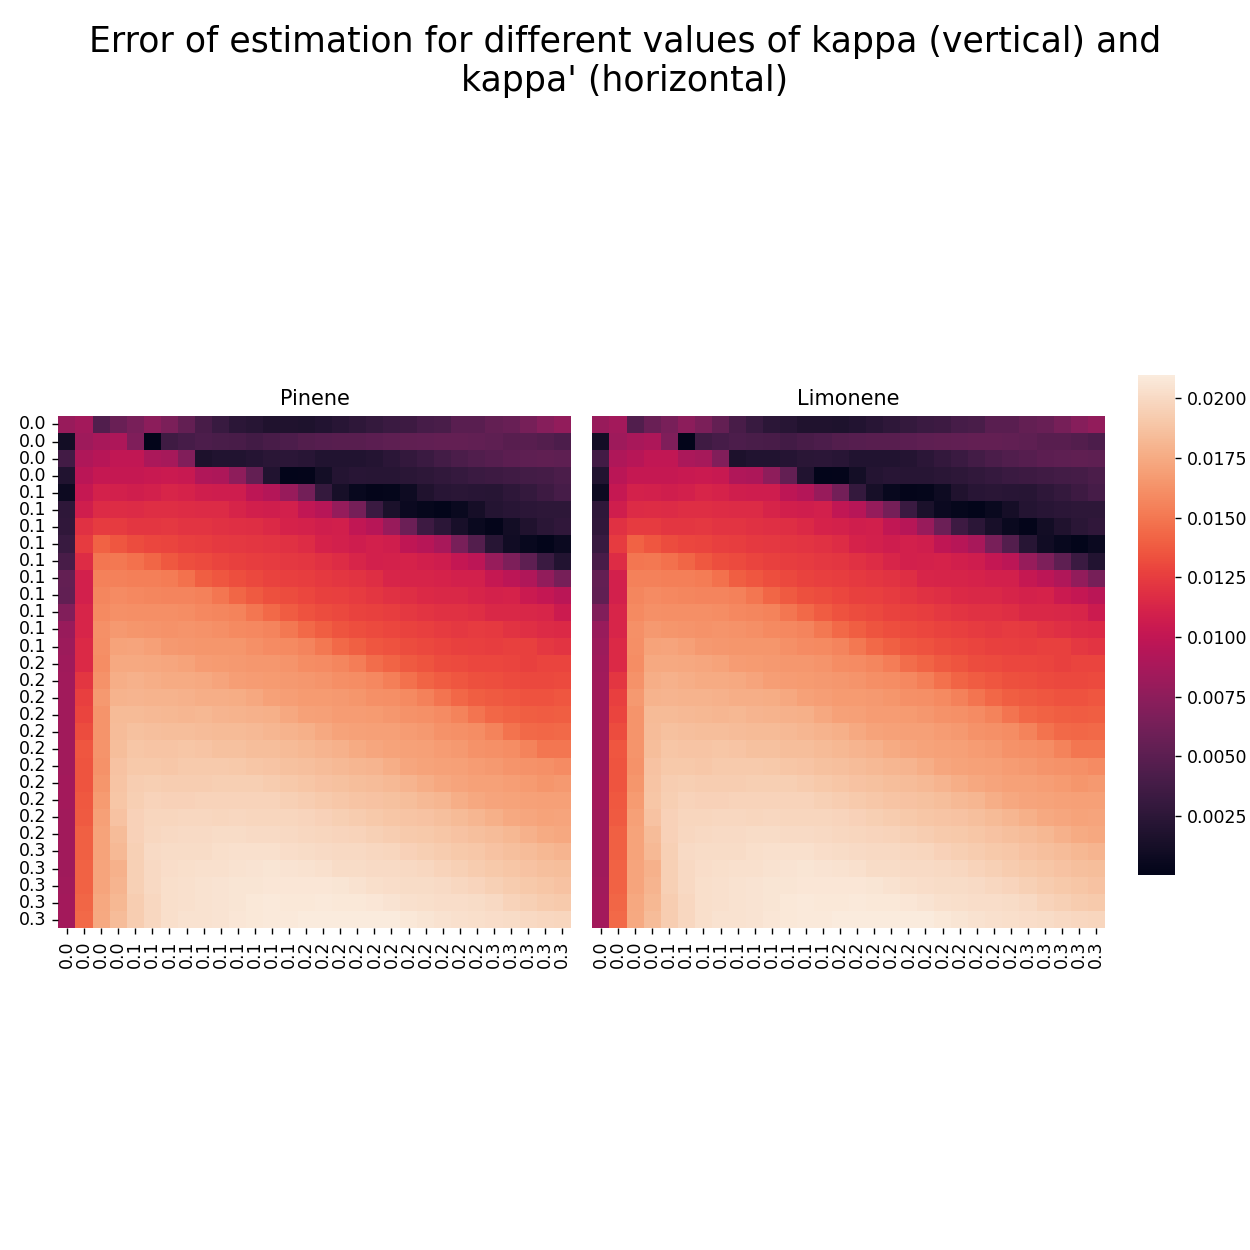

/tmp/ipykernel_185685/2789036394.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [44]:
vmin = min([df.min().min() for df in dataframes_ready_for_heatmap])
vmax = max([df.max().max() for df in dataframes_ready_for_heatmap])
labels = [round(x,1) for x in dataframes_ready_for_heatmap[0]]
#cbar_ax = fig.add_axes([0, 10, 20, 40])
names_for_plot = official_names

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10), gridspec_kw=dict(width_ratios=2*[1]))
plt.xlabel("kappa'", loc='left')
plt.ylabel('kappa', loc='top')


for i, ax in enumerate(axs.ravel()):
    ax.set_title(names_for_plot[i])
    if i%2==0:
        ax.set_ylabel('kappa')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, df in enumerate(dataframes_ready_for_heatmap):

    if i%2==0:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)
                #)
    else:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=False, cbar=False,
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True),
                )

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =20)


plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [45]:
all_components_results = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


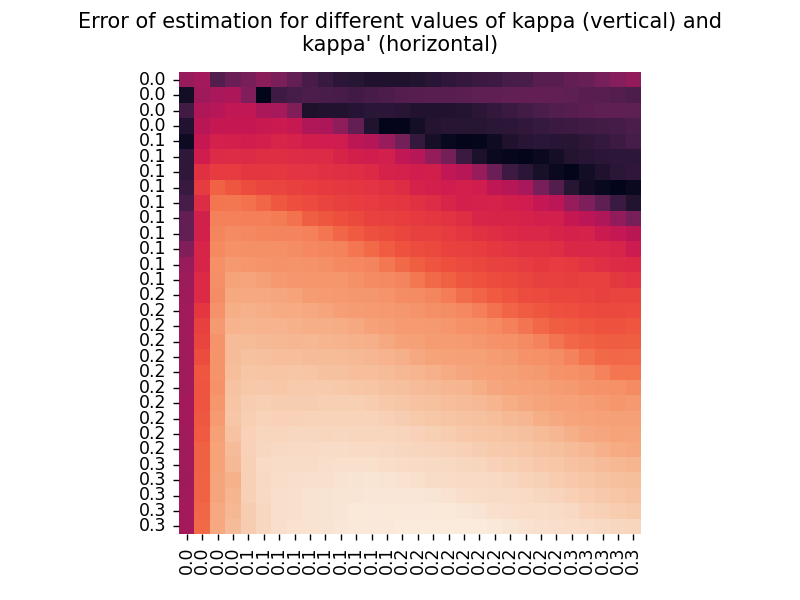

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=1, gridspec_kw=dict(width_ratios=[1]))
plt.xlabel("kappa'", loc='left')
plt.ylabel('kappa', loc='top')

vmin = all_components_results.min().min()
vmax = all_components_results.max().max()

#cbar_ax = fig.add_axes([0.1, 0.1, 0.5, 1])

sns.heatmap(all_components_results.astype(float), yticklabels=labels,  cbar=True,
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

#cbar_ax = fig.add_axes(rect = [0.1, 0.3, 0.4, 0.4])

plt.show()
#fig.tight_layout()
#fig.tight_layout(rect=[0, 0, .9, 1])

In [47]:
all_components_results.min().min()

2.9215978494923078e-05

In [48]:
all_components_results = all_components_results.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [49]:
all_components_results[0.29000000000000004][0.08]

2.9215978494923078e-05

### Estimation

In [51]:
estimation = estimate_proportions(mix, [comp0, comp1], 
                                   MTD=0.08, MTD_th=0.29, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 94.41it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(2.500089, 9.29988, 0), (2.500089, 9.29988, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38304.15it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(2.210089, 9.589879999999999)]


Splitting the experimental spectrum into chunks: 55902it [00:00, 1570009.86it/s]


Ion currents in chunks: [0.9999999999999976]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 223607 rows, 55905 columns and 565988 nonzeros
Model fingerprint: 0x0d1367b1
Coefficient statistics:
  Matrix range     [5e-12, 1e+00]
  Objective range  [5e-12, 1e+00]
  Bounds range     [1e-04, 1e-04]
  RHS range        [1e-04, 3e-01]
Presolve removed 5684 rows and 0 columns (presolve time = 5s) ...
Presolve removed 7763 rows and 0 columns (presolve time = 10s) ...
Presolve removed 9488 rows and 0 columns (presolve time = 15s) ...
Presolve removed 14815 rows and 0 columns (presolve time = 20s) ...
Presolve removed 64041 rows and 0 columns
Presolve time: 42.86s
Presolved: 55905 rows, 223606 columns, 565987 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.74s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9748464959409999
Noise proportion in experimental spectrum: 0.025153504062000093
Total explanation: 1.000000000003
Noise proportion in combination of theoretical spectra: 0.006719365239


In [52]:
estimation['proportion_of_noise_in_theoretical']

0.006719365238999984

In [53]:
estimated_visible_proportions = estimation['proportions']
estimated_visible_proportions

[0.49231172099699877, 0.4825347749439988]

In [54]:
estimated_molar_proportions = [est_mol_prop/prot 
                               for est_mol_prop, prot in zip(estimated_visible_proportions, protons)]
estimated_molar_proportions = [mp/sum(estimated_molar_proportions) for mp in estimated_molar_proportions]
estimated_molar_proportions

[0.5050146079889032, 0.49498539201109687]

In [55]:
molar_proportions

[0.505, 0.495]

In [56]:
real_visible_proportions

[0.505, 0.495]

### Visualisation of our estimation

In [57]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [58]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [59]:
p = estimated_visible_proportions

In [60]:
p = np.array(p).reshape(len(p),1)

In [61]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [62]:
components_ints = [comp_int.reshape(-1,1) for comp_int in components_ints]

In [63]:
X = np.concatenate(components_ints, axis=1)

In [64]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


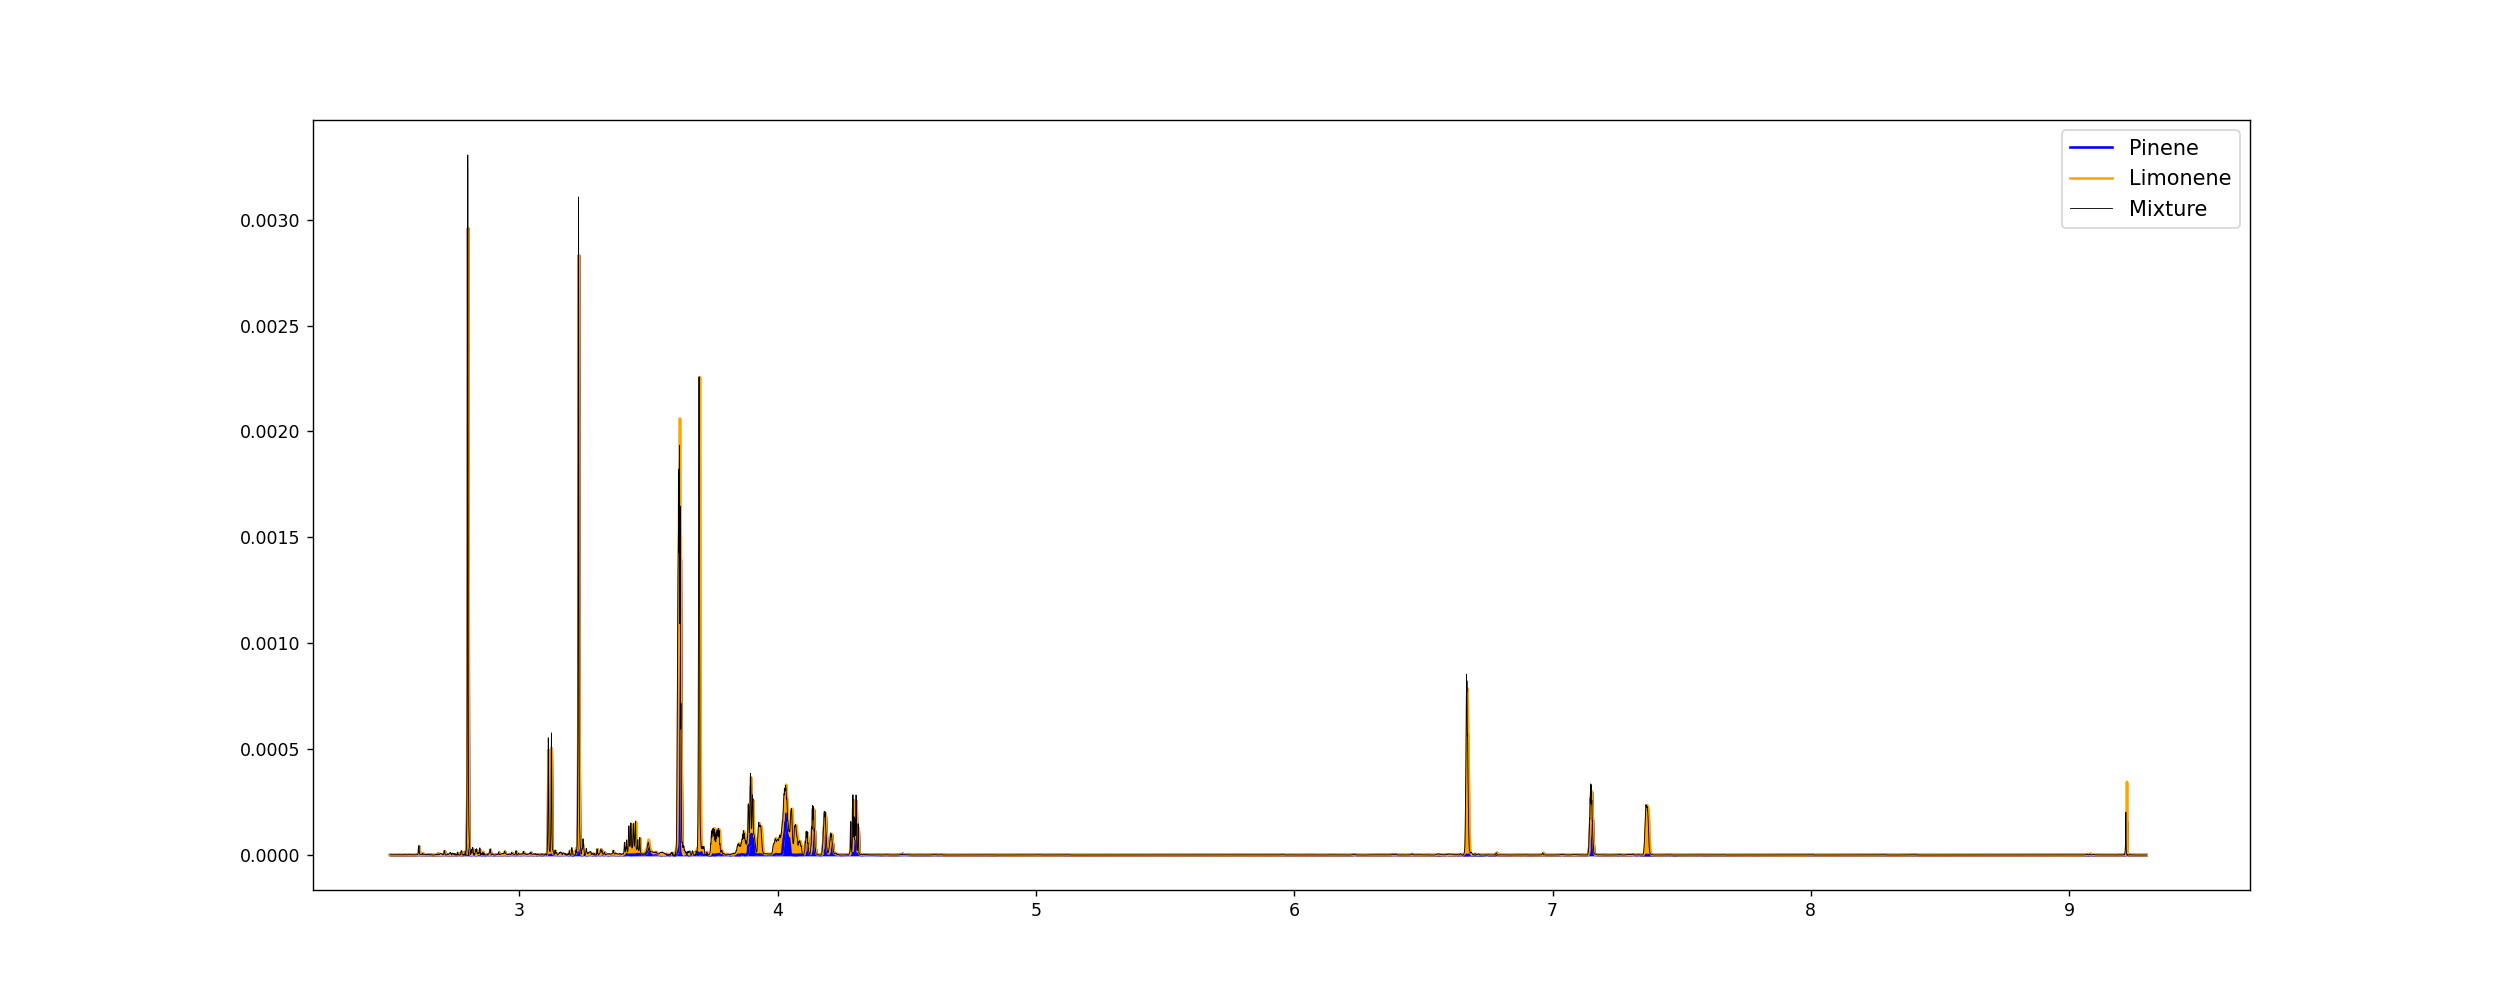

In [65]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(20, 8, forward=True)
ax.set_xlim(2.2, 9.7)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12})